In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import jpholiday
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


### 日本の休日

In [3]:
i = 0
df['holiday'] = np.zeros((len(df),))
jpholiday_list =[]
for date in df['datetime'].dt.date:
    DateJ = dt.date(date.year,date.month,date.day)
    jpholiday_list.append(jpholiday.is_holiday(DateJ))
    i += 1

df['holiday'] = jpholiday_list    
df['holiday'].value_counts()

False    2353
True      113
Name: holiday, dtype: int64

In [4]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.loc[df['close'] == 1, 'price_am'] = 0
df.loc[df['close'] == 1, 'price_pm'] = 0
df.head()

,datetime,y,client,close,price_am,price_pm,holiday
0,2010-07-01,17.0,0,0,NaN,NaN,False
1,2010-07-02,18.0,0,0,NaN,NaN,False
2,2010-07-03,20.0,0,0,NaN,NaN,False
3,2010-07-04,20.0,0,0,NaN,NaN,False
4,2010-07-05,14.0,0,0,NaN,NaN,False


In [5]:
### datimeをdatetime64[ns]型に変更。

In [6]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [7]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [8]:
df = encode(df, 'month')
df = encode(df, 'day')
df = encode(df, 'weekday')

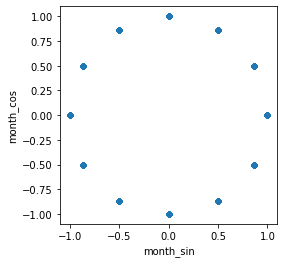

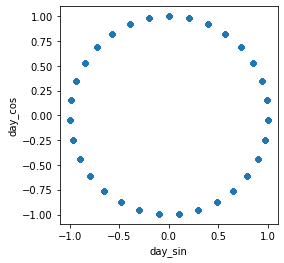

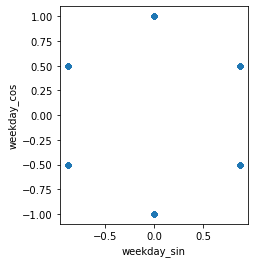

In [9]:
df.plot.scatter('month_sin','month_cos').set_aspect('equal')
df.plot.scatter('day_sin','day_cos').set_aspect('equal')
df.plot.scatter('weekday_sin','weekday_cos').set_aspect('equal')

In [10]:
df.head()
#df.info()
#df['epoch'] = df['datetime'].map(pd.Timestamp.timestamp) # TimeStamp型に変更
#display(df['epoch'])

,datetime,y,client,close,price_am,price_pm,holiday,year,month,day,weekday,month_cos,month_sin,day_cos,day_sin,weekday_cos,weekday_sin
0,2010-07-01,17.0,0,0,NaN,NaN,False,2010,7,1,3,-0.866025,-0.5,0.979530,0.201299,-1.0,1.224647e-16
1,2010-07-02,18.0,0,0,NaN,NaN,False,2010,7,2,4,-0.866025,-0.5,0.918958,0.394356,-0.5,-8.660254e-01
2,2010-07-03,20.0,0,0,NaN,NaN,False,2010,7,3,5,-0.866025,-0.5,0.820763,0.571268,0.5,-8.660254e-01
3,2010-07-04,20.0,0,0,NaN,NaN,False,2010,7,4,6,-0.866025,-0.5,0.688967,0.724793,1.0,-2.449294e-16
4,2010-07-05,14.0,0,0,NaN,NaN,False,2010,7,5,0,-0.866025,-0.5,0.528964,0.848644,1.0,0.000000e+00


In [11]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [12]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

In [13]:
# 各月,曜日ごとの価格のばらつき
df['price_am_std'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.std())
df['price_pm_std'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.std())

### New features

In [14]:
df['price'] = (df['price_am'] + df['price_pm'])/2
df['price_times'] = df['price_am'] * df['price_pm']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             2101 non-null   float64
 1   client        2466 non-null   int64  
 2   close         2466 non-null   int64  
 3   price_am      2466 non-null   float64
 4   price_pm      2466 non-null   float64
 5   holiday       2466 non-null   bool   
 6   year          2466 non-null   int64  
 7   month         2466 non-null   int64  
 8   day           2466 non-null   int64  
 9   weekday       2466 non-null   int64  
 10  month_cos     2466 non-null   float64
 11  month_sin     2466 non-null   float64
 12  day_cos       2466 non-null   float64
 13  day_sin       2466 non-null   float64
 14  weekday_cos   2466 non-null   float64
 15  weekday_sin   2466 non-null   float64
 16  price_am_std  2466 non-null   float64
 17  price_pm_std  2466 non-null   float64
 18  price         2466 non-null  

In [16]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.129032  0.000000  23.423077
      1        0.096774  0.064516  21.846154
      2        0.033333  0.000000  22.692308
      3        0.161290  0.096774  21.296296
      4        0.258065  0.161290  27.444444
      5        0.806452  0.419355  36.296296
      6        0.375000  0.218750  32.666667
2     0        0.586207  0.344828  40.160000
      1        0.357143  0.178571  34.083333
      2        0.379310  0.206897  34.440000
      3        0.357143  0.142857  34.041667
      4        0.821429  0.500000  39.083333
      5        2.071429  1.535714  46.416667
      6        1.392857  0.892857  43.000000
3     0        1.933333  1.666667  58.576923
      1        2.000000  1.580645  59.185185
      2        1.838710  1.709677  56.500000
      3        2.031250  1.656250  56.814815
      4        2.096774  2.032258  58.038462
      5        3.096774  2.741935  59.407407
      6   

<ipython-input-16-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-16-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [17]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)
# df['day'] = df['day'].astype(str)
#df=df.drop(['month'], axis=1)
#df=df.drop(['day'], axis=1)
#df=df.drop(['weekday'], axis=1)

In [18]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'holiday', 'year', 'day', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'weekday_cos', 'weekday_sin', 'price_am_std', 'price_pm_std', 'price', 'price_times']


### Pandas Profining

In [19]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

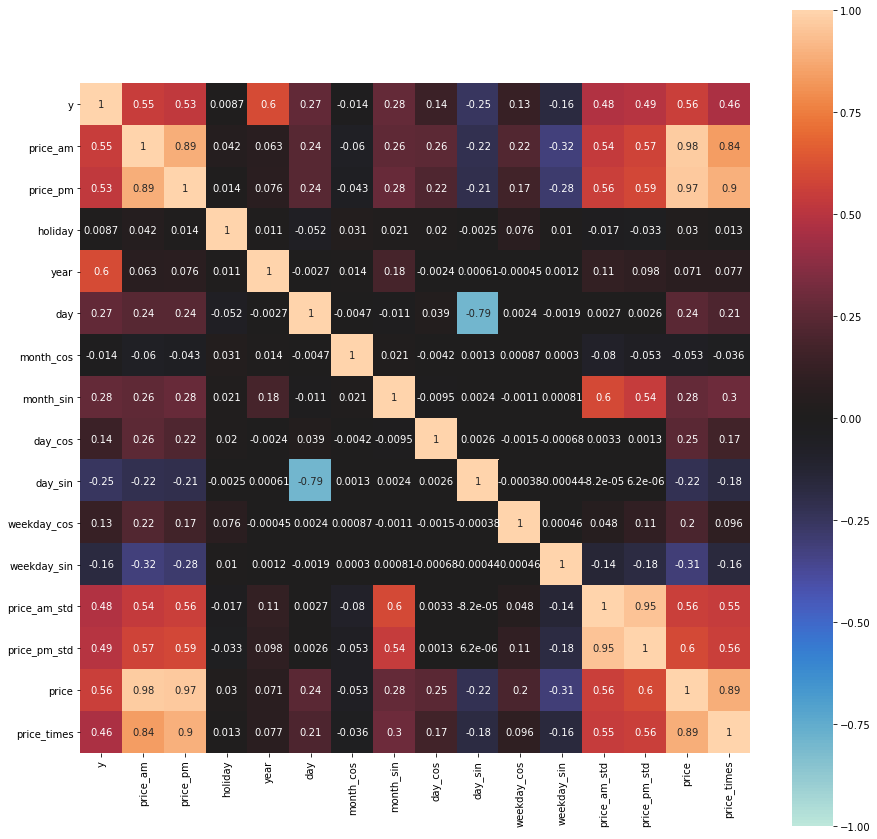

In [20]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


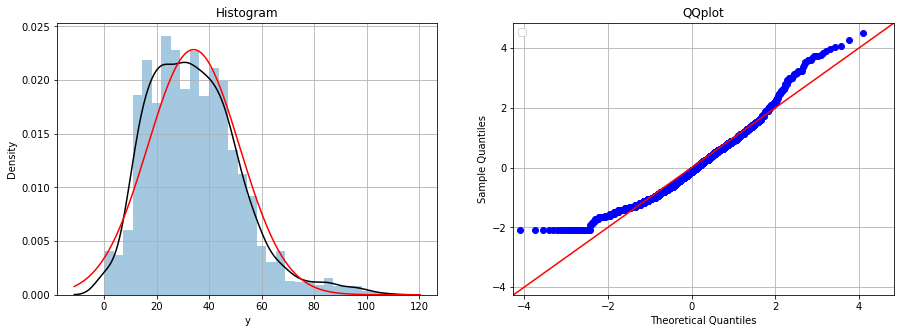

In [21]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [22]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [23]:
df.head(10)
len(train)

2101

In [24]:
#df[['price_am', 'price_pm']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tmp = df[['price_am', 'price_pm']].to_numpy()
X_train_tmp = X_tmp[:len(train)]
X_test_tmp = X_tmp[len(train):]

scaler.fit(X_train_tmp)
X_train_scaled = scaler.transform(X_train_tmp)
X_test_scaled = scaler.transform(X_test_tmp)

print(X_train_tmp)
print(X_train_scaled)

df_train = pd.DataFrame(X_train_scaled)
df_test = pd.DataFrame(X_test_scaled)
#df_concat = pd.concat([df_train,df_test], sort=False)
df[['price_am', 'price_pm']] = pd.concat([df_train,df_test], sort=False)
df.head()

[[0.19230769 0.07692308]
 [0.69230769 0.42307692]
 [1.80769231 1.19230769]
 ...
 [4.         4.        ]
 [5.         4.        ]
 [5.         4.        ]]
[[-0.5701635  -0.51549656]
 [-0.07417687 -0.11655155]
 [ 1.03225484  0.76999291]
 ...
 [ 3.20696545  4.00588022]
 [ 4.19893871  4.00588022]
 [ 4.19893871  4.00588022]]


,y,price_am,price_pm,holiday,year,day,month_cos,month_sin,day_cos,day_sin,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,-0.570164,-0.515497,False,2010,1,-0.866025,-0.5,0.979530,0.201299,...,0,1,0,0,0,0,1,0,0,0
1,18.0,-0.074177,-0.116552,False,2010,2,-0.866025,-0.5,0.918958,0.394356,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.032255,0.769993,False,2010,3,-0.866025,-0.5,0.820763,0.571268,...,0,1,0,0,0,0,0,0,1,0
3,20.0,0.635183,0.462986,False,2010,4,-0.866025,-0.5,0.688967,0.724793,...,0,1,0,0,0,0,0,0,0,1
4,14.0,-0.417552,-0.382515,False,2010,5,-0.866025,-0.5,0.528964,0.848644,...,0,1,0,0,0,0,0,0,0,0


### Separate Data

In [25]:
train = df[:len(train)]
test = df[len(train):]

In [26]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [27]:
### 線形回帰

In [28]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [29]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             2101 non-null   float64
 1   price_am      2466 non-null   float64
 2   price_pm      2466 non-null   float64
 3   holiday       2466 non-null   bool   
 4   year          2466 non-null   int64  
 5   day           2466 non-null   int64  
 6   month_cos     2466 non-null   float64
 7   month_sin     2466 non-null   float64
 8   day_cos       2466 non-null   float64
 9   day_sin       2466 non-null   float64
 10  weekday_cos   2466 non-null   float64
 11  weekday_sin   2466 non-null   float64
 12  price_am_std  2466 non-null   float64
 13  price_pm_std  2466 non-null   float64
 14  price         2466 non-null   float64
 15  price_times   2466 non-null   float64
 16  client_1      2466 non-null   uint8  
 17  close_1       2466 non-null   uint8  
 18  month_10      2466 non-null  

,y,price_am,price_pm,holiday,year,day,month_cos,month_sin,day_cos,day_sin,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,-0.570164,-0.515497,False,2010,1,-0.866025,-0.5,0.979530,0.201299,...,0,1,0,0,0,0,1,0,0,0
1,18.0,-0.074177,-0.116552,False,2010,2,-0.866025,-0.5,0.918958,0.394356,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.032255,0.769993,False,2010,3,-0.866025,-0.5,0.820763,0.571268,...,0,1,0,0,0,0,0,0,1,0
3,20.0,0.635183,0.462986,False,2010,4,-0.866025,-0.5,0.688967,0.724793,...,0,1,0,0,0,0,0,0,0,1
4,14.0,-0.417552,-0.382515,False,2010,5,-0.866025,-0.5,0.528964,0.848644,...,0,1,0,0,0,0,0,0,0,0


In [30]:
## データセットの標準化準備
##scaler= StandardScaler()
## データセットの標準化
#scaler.fit(X_train)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)


In [31]:
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2).fit(X_train_scaler[:,0:1])
#X_train_poly=poly.transform(X_train_scaler[:,0:1])
#X_test_poly=poly.transform(X_test_scaler[:,0:1])
#print("X_train.shape: {}".format(X_train.shape))
#print("X_train_poly.shape: {}".format(X_train_poly.shape))

In [32]:
X_train.head()

,price_am,price_pm,holiday,year,day,month_cos,month_sin,day_cos,day_sin,weekday_cos,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,-0.570164,-0.515497,False,2010,1,-0.866025,-0.5,0.979530,0.201299,-1.0,...,0,1,0,0,0,0,1,0,0,0
1,-0.074177,-0.116552,False,2010,2,-0.866025,-0.5,0.918958,0.394356,-0.5,...,0,1,0,0,0,0,0,1,0,0
2,1.032255,0.769993,False,2010,3,-0.866025,-0.5,0.820763,0.571268,0.5,...,0,1,0,0,0,0,0,0,1,0
3,0.635183,0.462986,False,2010,4,-0.866025,-0.5,0.688967,0.724793,1.0,...,0,1,0,0,0,0,0,0,0,1
4,-0.417552,-0.382515,False,2010,5,-0.866025,-0.5,0.528964,0.848644,1.0,...,0,1,0,0,0,0,0,0,0,0


In [33]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.0031622776601682888}
R^2 = 0.7556135633629052
MAE = 6.707557715220186


C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1928.6963081468712, tolerance: 64.13793860066633
  model = cd_fast.enet_coordinate_descent(


In [34]:
import optuna.integration.lightgbm as lgb # Optuna 
#import lightgbm as lgb 
from sklearn.model_selection import KFold

evals_result = {} #結果を格納するための辞書

In [35]:
def SVC_fit(random_sts):
    # SVM
    params_grid = [
        {'C': [1, 10, 100], 'kernel':['linear']},
        {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
    ]
    # パラメータチューニング
    clf = GridSearchCV(
        estimator = SVC(),
        param_grid = params_grid,
        cv = 5,
        scoring='r2',
        n_jobs = -1
        )

    # フィッテイング
    clf.fit(X_train, y_train) 

    # チューニングしたモデル
    best_param = clf.best_params_
    svc_tuned = clf.best_estimator_

    # 予測値を反映
    y_pred = svc_tuned.predict(X_train) # Trainデータに対して予測
    y_test_pred = svc_tuned.predict(X_test) # Testデータに対して予測

    print(best_param)
    print("Score = {}".format(clf.score(X_train, y_train)))
    print("MAE = {}".format(mean_absolute_error(y_train, y_pred)))
    mae_result = mean_absolute_error(y_train, y_pred)
    
    X_train['svc'] = y_pred
    X_test['svc'] = y_test_pred

    return y_pred, y_test_pred, mae_result
    

In [36]:
def lightGBM_fit(random_sts):
    y_lgb_preds = []
    models = []
    y_lgb_oof_train = np.zeros((len(X_train),))
    cv = KFold(n_splits=5, shuffle=True, random_state=random_sts)

    params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective': 'regression',
        'metric' : 'rmse',
        'max_bin' : 255,
        'num_leaves' : 31,
        'learning_rate' : 0.05,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : -1
    }

    # Cross Validation
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]
    
        # Train Dataset
        lgb_train = lgb.Dataset(X_tr, y_tr)

        # Evaluation Dataset (early_stopping_rounds)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
 #       evals_result = {} #結果を格納するための辞書
        # train
        gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
        # Out-of-hold of train data
        y_lgb_oof_train[valid_index] = \
            gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
        # Prediction for X_test data
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
        # Append Prediction data 
        y_lgb_preds.append(y_pred)
        models.append(gbm)

    mae_result = mean_absolute_error(y_train, y_lgb_oof_train)
    print("MAE = {}".format(mae_result))
    
    X_train['lgb'] = y_lgb_oof_train
    X_test['lgb'] = sum(y_lgb_preds)/len(y_lgb_preds)

    return y_lgb_oof_train, y_lgb_preds, mae_result

In [37]:
svc_mae_result = []
lgb_mae_result = []
for i in range(0,1):
    y_svc_pred, y_svc_test_pred,mae_result = SVC_fit(i)
    svc_mae_result.append(mae_result)
    print(X_train.tail())
    y_lgb_oof_train, y_lgb_preds, mae_result = lightGBM_fit(i)
    lgb_mae_result.append(mae_result)
    print(X_train.tail())

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


[I 2021-07-03 17:57:25,576] A new study created in memory with name: no-name-ebec218c-4f61-4689-ac0a-0ee7de13d300
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Score = 0.7919125514292513
MAE = 5.293193717277487
      price_am  price_pm  holiday  year  day     month_cos  month_sin  \
2096  4.198939   4.00588    False  2016   27  6.123234e-17        1.0   
2097  3.206965   4.00588    False  2016   28  6.123234e-17        1.0   
2098  3.206965   4.00588    False  2016   29  6.123234e-17        1.0   
2099  4.198939   4.00588    False  2016   30  6.123234e-17        1.0   
2100  4.198939   4.00588    False  2016   31  6.123234e-17        1.0   

       day_cos       day_sin  weekday_cos  ...  month_7  month_8  month_9  \
2096  0.688967 -7.247928e-01          1.0  ...        0        0        0   
2097  0.820763 -5.712682e-01          1.0  ...        0        0        0   
2098  0.918958 -3.943559e-01          0.5  ...        0        0        0   
2099  0.979530 -2.012985e-01         -0.5  ...        0        0        0   
2100  1.000000 -2.449294e-16         -1.0  ...        0        0        0   

      weekday_1  weekday_2  weekday_3  weekday_

feature_fraction, val_score: 6.777970:  14%|######4                                      | 1/7 [00:00<00:02,  2.13it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.52379	eval's rmse: 6.77797
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.98127	eval's rmse: 6.99247
[200]	train's rmse: 3.92989	eval's rmse: 6.88599


feature_fraction, val_score: 6.777970:  29%|############8                                | 2/7 [00:01<00:02,  1.97it/s]

Early stopping, best iteration is:
[173]	train's rmse: 4.15912	eval's rmse: 6.8773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.9596	eval's rmse: 6.99739
[200]	train's rmse: 3.91799	eval's rmse: 6.93617


feature_fraction, val_score: 6.777970:  43%|###################2                         | 3/7 [00:01<00:02,  1.98it/s]

Early stopping, best iteration is:
[158]	train's rmse: 4.268	eval's rmse: 6.89849
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97495	eval's rmse: 6.98909
[200]	train's rmse: 3.96314	eval's rmse: 6.92347


feature_fraction, val_score: 6.777970:  57%|#########################7                   | 4/7 [00:02<00:01,  1.99it/s]

Early stopping, best iteration is:
[157]	train's rmse: 4.3184	eval's rmse: 6.87951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.06776	eval's rmse: 6.8912
[200]	train's rmse: 4.0556	eval's rmse: 6.85308


feature_fraction, val_score: 6.777970:  71%|################################1            | 5/7 [00:02<00:01,  1.97it/s]

Early stopping, best iteration is:
[172]	train's rmse: 4.2741	eval's rmse: 6.82834
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00608	eval's rmse: 6.87878
[200]	train's rmse: 4.0089	eval's rmse: 6.85766


feature_fraction, val_score: 6.777970:  86%|######################################5      | 6/7 [00:03<00:00,  2.00it/s]

Early stopping, best iteration is:
[159]	train's rmse: 4.33158	eval's rmse: 6.82275
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00512	eval's rmse: 7.1026
[200]	train's rmse: 3.9193	eval's rmse: 7.08325


num_leaves, val_score: 6.777970:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[158]	train's rmse: 4.28226	eval's rmse: 7.04724
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352


num_leaves, val_score: 6.777970:   5%|##5                                               | 1/20 [00:00<00:12,  1.49it/s]

[200]	train's rmse: 3.75253	eval's rmse: 6.89086
Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352


num_leaves, val_score: 6.777970:  10%|#####                                             | 2/20 [00:01<00:11,  1.63it/s]

[200]	train's rmse: 3.75253	eval's rmse: 6.89086
Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92102	eval's rmse: 6.90416


num_leaves, val_score: 6.777970:  15%|#######5                                          | 3/20 [00:01<00:11,  1.53it/s]

[200]	train's rmse: 3.83991	eval's rmse: 6.83215
Early stopping, best iteration is:
[155]	train's rmse: 4.23834	eval's rmse: 6.79006
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41725	eval's rmse: 6.86507


num_leaves, val_score: 6.709645:  15%|#######5                                          | 3/20 [00:02<00:11,  1.53it/s]

[200]	train's rmse: 4.51701	eval's rmse: 6.73319
[300]	train's rmse: 4.01471	eval's rmse: 6.74669
Early stopping, best iteration is:
[251]	train's rmse: 4.23911	eval's rmse: 6.70964


num_leaves, val_score: 6.709645:  20%|##########                                        | 4/20 [00:02<00:09,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352


num_leaves, val_score: 6.709645:  25%|############5                                     | 5/20 [00:03<00:08,  1.71it/s]

[200]	train's rmse: 3.75253	eval's rmse: 6.89086
Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352


num_leaves, val_score: 6.709645:  30%|###############                                   | 6/20 [00:03<00:08,  1.75it/s]

[200]	train's rmse: 3.75253	eval's rmse: 6.89086
Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352


num_leaves, val_score: 6.709645:  35%|#################5                                | 7/20 [00:04<00:07,  1.74it/s]

[200]	train's rmse: 3.75253	eval's rmse: 6.89086
Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352
[200]	train's rmse: 3.75253	eval's rmse: 6.89086


num_leaves, val_score: 6.709645:  40%|####################                              | 8/20 [00:04<00:06,  1.77it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.014	eval's rmse: 6.96186
[200]	train's rmse: 3.95479	eval's rmse: 6.88789


num_leaves, val_score: 6.709645:  45%|######################5                           | 9/20 [00:05<00:06,  1.80it/s]

Early stopping, best iteration is:
[159]	train's rmse: 4.29604	eval's rmse: 6.84199
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352
[200]	train's rmse: 3.75253	eval's rmse: 6.89086


num_leaves, val_score: 6.709645:  50%|########################5                        | 10/20 [00:05<00:05,  1.81it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.17776	eval's rmse: 8.31634
[200]	train's rmse: 7.38256	eval's rmse: 7.36788
[300]	train's rmse: 7.21828	eval's rmse: 7.18649
[400]	train's rmse: 7.13102	eval's rmse: 7.13592
[500]	train's rmse: 7.07136	eval's rmse: 7.12151
[600]	train's rmse: 7.02696	eval's rmse: 7.10526
[700]	train's rmse: 6.9904	eval's rmse: 7.0755
[800]	train's rmse: 6.96136	eval's rmse: 7.0686


num_leaves, val_score: 6.709645:  55%|##########################9                      | 11/20 [00:06<00:04,  1.93it/s]

Early stopping, best iteration is:
[792]	train's rmse: 6.96285	eval's rmse: 7.06589
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92102	eval's rmse: 6.90416
[200]	train's rmse: 3.83991	eval's rmse: 6.83215


num_leaves, val_score: 6.709645:  60%|#############################4                   | 12/20 [00:06<00:04,  1.91it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.23834	eval's rmse: 6.79006
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06414	eval's rmse: 6.8561
[200]	train's rmse: 5.32114	eval's rmse: 6.71538
[300]	train's rmse: 4.88435	eval's rmse: 6.6885


num_leaves, val_score: 6.665238:  65%|###############################8                 | 13/20 [00:07<00:03,  1.98it/s]

[400]	train's rmse: 4.55107	eval's rmse: 6.69083
Early stopping, best iteration is:
[351]	train's rmse: 4.70479	eval's rmse: 6.66524
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06414	eval's rmse: 6.8561
[200]	train's rmse: 5.32114	eval's rmse: 6.71538
[300]	train's rmse: 4.88435	eval's rmse: 6.6885


num_leaves, val_score: 6.665238:  70%|##################################3              | 14/20 [00:07<00:03,  1.97it/s]

[400]	train's rmse: 4.55107	eval's rmse: 6.69083
Early stopping, best iteration is:
[351]	train's rmse: 4.70479	eval's rmse: 6.66524
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352
[200]	train's rmse: 3.75253	eval's rmse: 6.89086


num_leaves, val_score: 6.665238:  75%|####################################7            | 15/20 [00:08<00:02,  1.92it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.42146	eval's rmse: 7.383
[200]	train's rmse: 6.94505	eval's rmse: 6.97335
[300]	train's rmse: 6.73073	eval's rmse: 6.83083
[400]	train's rmse: 6.5712	eval's rmse: 6.7878
[500]	train's rmse: 6.43555	eval's rmse: 6.76541
[600]	train's rmse: 6.33458	eval's rmse: 6.75077
[700]	train's rmse: 6.22061	eval's rmse: 6.70212

num_leaves, val_score: 6.665238:  80%|#######################################2         | 16/20 [00:08<00:02,  1.96it/s]


[800]	train's rmse: 6.13914	eval's rmse: 6.70655
Early stopping, best iteration is:
[775]	train's rmse: 6.15662	eval's rmse: 6.69501
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352


num_leaves, val_score: 6.665238:  85%|#########################################6       | 17/20 [00:09<00:01,  1.93it/s]

[200]	train's rmse: 3.75253	eval's rmse: 6.89086
Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33177	eval's rmse: 6.89303
[200]	train's rmse: 5.66061	eval's rmse: 6.70196


num_leaves, val_score: 6.652627:  90%|############################################1    | 18/20 [00:09<00:00,  2.12it/s]

[300]	train's rmse: 5.25131	eval's rmse: 6.66139
Early stopping, best iteration is:
[252]	train's rmse: 5.43376	eval's rmse: 6.65263
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352
[200]	train's rmse: 3.75253	eval's rmse: 6.89086


num_leaves, val_score: 6.652627:  95%|##############################################5  | 19/20 [00:10<00:00,  2.02it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.87529	eval's rmse: 6.95352
[200]	train's rmse: 3.75253	eval's rmse: 6.89086


bagging, val_score: 6.652627:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[155]	train's rmse: 4.16043	eval's rmse: 6.85089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37685	eval's rmse: 6.96573
[200]	train's rmse: 5.67415	eval's rmse: 6.76696
[300]	train's rmse: 5.2663	eval's rmse: 6.72956


bagging, val_score: 6.652627:  10%|#####3                                               | 1/10 [00:00<00:03,  2.67it/s]

Early stopping, best iteration is:
[298]	train's rmse: 5.27343	eval's rmse: 6.72494
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25708	eval's rmse: 6.76567


bagging, val_score: 6.537652:  20%|##########6                                          | 2/10 [00:00<00:02,  2.81it/s]

[200]	train's rmse: 5.57997	eval's rmse: 6.57323
[300]	train's rmse: 5.16746	eval's rmse: 6.54674
Early stopping, best iteration is:
[276]	train's rmse: 5.2631	eval's rmse: 6.53765
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26506	eval's rmse: 6.82978
[200]	train's rmse: 5.57262	eval's rmse: 6.62881


bagging, val_score: 6.537652:  30%|###############9                                     | 3/10 [00:01<00:02,  2.51it/s]

[300]	train's rmse: 5.1614	eval's rmse: 6.56247
[400]	train's rmse: 4.86274	eval's rmse: 6.55335
Early stopping, best iteration is:
[375]	train's rmse: 4.93218	eval's rmse: 6.54429
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33007	eval's rmse: 6.87873
[200]	train's rmse: 5.61426	eval's rmse: 6.68304


bagging, val_score: 6.537652:  40%|#####################2                               | 4/10 [00:01<00:02,  2.77it/s]

[300]	train's rmse: 5.23787	eval's rmse: 6.69992
Early stopping, best iteration is:
[213]	train's rmse: 5.56777	eval's rmse: 6.66644
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41277	eval's rmse: 6.92958
[200]	train's rmse: 5.74456	eval's rmse: 6.78725
[300]	train's rmse: 5.34374	eval's rmse: 6.78038


bagging, val_score: 6.537652:  50%|##########################5                          | 5/10 [00:02<00:02,  2.24it/s]

[400]	train's rmse: 5.06124	eval's rmse: 6.74214
[500]	train's rmse: 4.82966	eval's rmse: 6.7711
Early stopping, best iteration is:
[418]	train's rmse: 5.02186	eval's rmse: 6.73132
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.58711	eval's rmse: 7.20277
[200]	train's rmse: 5.97786	eval's rmse: 7.08976
[300]	train's rmse: 5.61213	eval's rmse: 7.06358


bagging, val_score: 6.537652:  60%|###############################8                     | 6/10 [00:02<00:01,  2.29it/s]

[400]	train's rmse: 5.31309	eval's rmse: 6.97136
Early stopping, best iteration is:
[387]	train's rmse: 5.33942	eval's rmse: 6.95816
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20371	eval's rmse: 6.80809
[200]	train's rmse: 5.56813	eval's rmse: 6.62351
[300]	train's rmse: 5.15032	eval's rmse: 6.59041
[400]	train's rmse: 4.84943	eval's rmse: 6.57333

bagging, val_score: 6.537652:  70%|#####################################                | 7/10 [00:02<00:01,  2.27it/s]


[500]	train's rmse: 4.61597	eval's rmse: 6.57881
Early stopping, best iteration is:
[417]	train's rmse: 4.80515	eval's rmse: 6.5623
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.537652:  80%|##########################################4          | 8/10 [00:03<00:00,  2.54it/s]

[100]	train's rmse: 6.32664	eval's rmse: 6.93691
[200]	train's rmse: 5.61996	eval's rmse: 6.73834
[300]	train's rmse: 5.23509	eval's rmse: 6.72872
Early stopping, best iteration is:
[225]	train's rmse: 5.5236	eval's rmse: 6.70086
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44163	eval's rmse: 7.04309
[200]	train's rmse: 5.79114	eval's rmse: 6.86343


bagging, val_score: 6.537652:  90%|###############################################7     | 9/10 [00:03<00:00,  2.70it/s]

[300]	train's rmse: 5.41033	eval's rmse: 6.9127
Early stopping, best iteration is:
[223]	train's rmse: 5.67344	eval's rmse: 6.84085
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32736	eval's rmse: 6.86888


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[200]	train's rmse: 5.65325	eval's rmse: 6.72344
[300]	train's rmse: 5.25429	eval's rmse: 6.67551
[400]	train's rmse: 4.94311	eval's rmse: 6.69325
Early stopping, best iteration is:
[308]	train's rmse: 5.22313	eval's rmse: 6.66923


feature_fraction_stage2, val_score: 6.537652:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23771	eval's rmse: 6.82596
[200]	train's rmse: 5.58083	eval's rmse: 6.59199


feature_fraction_stage2, val_score: 6.537652:  33%|############6                         | 1/3 [00:00<00:00,  2.25it/s]

[300]	train's rmse: 5.16531	eval's rmse: 6.55931
[400]	train's rmse: 4.84081	eval's rmse: 6.57204
Early stopping, best iteration is:
[361]	train's rmse: 4.95861	eval's rmse: 6.55196
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462
[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903


feature_fraction_stage2, val_score: 6.505966:  67%|#########################3            | 2/3 [00:00<00:00,  2.37it/s]

Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25818	eval's rmse: 6.78029
[200]	train's rmse: 5.58506	eval's rmse: 6.55065
[300]	train's rmse: 5.17405	eval's rmse: 6.52944
[400]	train's rmse: 4.84672	eval's rmse: 6.54186
Early stopping, best iteration is:
[340]	train's rmse: 5.04268	eval's rmse: 6.51006


regularization_factors, val_score: 6.505966:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32663	eval's rmse: 6.81894
[200]	train's rmse: 5.64263	eval's rmse: 6.57925


regularization_factors, val_score: 6.505966:   0%|                                              | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 5.25003	eval's rmse: 6.54138
[400]	train's rmse: 4.9366	eval's rmse: 6.53472
[500]	train's rmse: 4.68941	eval's rmse: 6.53369
Early stopping, best iteration is:
[414]	train's rmse: 4.90049	eval's rmse: 6.52823


regularization_factors, val_score: 6.505966:   5%|#9                                    | 1/20 [00:00<00:08,  2.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23772	eval's rmse: 6.82228
[200]	train's rmse: 5.55638	eval's rmse: 6.59439


regularization_factors, val_score: 6.505966:  10%|###8                                  | 2/20 [00:00<00:07,  2.25it/s]

[300]	train's rmse: 5.15078	eval's rmse: 6.55754
[400]	train's rmse: 4.83758	eval's rmse: 6.55832
Early stopping, best iteration is:
[353]	train's rmse: 4.98464	eval's rmse: 6.54046
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26631	eval's rmse: 6.82392
[200]	train's rmse: 5.61292	eval's rmse: 6.61675
[300]	train's rmse: 5.24021	eval's rmse: 6.55517


regularization_factors, val_score: 6.505966:  15%|#####7                                | 3/20 [00:01<00:07,  2.24it/s]

[400]	train's rmse: 4.94537	eval's rmse: 6.54509
Early stopping, best iteration is:
[381]	train's rmse: 5.00051	eval's rmse: 6.53354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82776
[200]	train's rmse: 5.57858	eval's rmse: 6.58462
[300]	train's rmse: 5.17958	eval's rmse: 6.53294


regularization_factors, val_score: 6.505966:  20%|#######6                              | 4/20 [00:01<00:07,  2.26it/s]

[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2499	eval's rmse: 6.80208
[200]	train's rmse: 5.57273	eval's rmse: 6.54289
[300]	train's rmse: 5.15937	eval's rmse: 6.53198


regularization_factors, val_score: 6.505966:  25%|#########5                            | 5/20 [00:02<00:06,  2.25it/s]

[400]	train's rmse: 4.83583	eval's rmse: 6.5321
Early stopping, best iteration is:
[369]	train's rmse: 4.93248	eval's rmse: 6.51656
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25386	eval's rmse: 6.83854
[200]	train's rmse: 5.59418	eval's rmse: 6.61274
[300]	train's rmse: 5.2035	eval's rmse: 6.56558


regularization_factors, val_score: 6.505966:  30%|###########4                          | 6/20 [00:02<00:06,  2.22it/s]

[400]	train's rmse: 4.8962	eval's rmse: 6.53851
[500]	train's rmse: 4.65838	eval's rmse: 6.52916
Early stopping, best iteration is:
[419]	train's rmse: 4.84631	eval's rmse: 6.52577
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  35%|#############3                        | 7/20 [00:03<00:05,  2.20it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23798	eval's rmse: 6.82243
[200]	train's rmse: 5.56595	eval's rmse: 6.5909


regularization_factors, val_score: 6.505966:  40%|###############2                      | 8/20 [00:03<00:05,  2.23it/s]

[300]	train's rmse: 5.15075	eval's rmse: 6.57224
[400]	train's rmse: 4.83414	eval's rmse: 6.56897
Early stopping, best iteration is:
[377]	train's rmse: 4.90864	eval's rmse: 6.55362
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82776
[200]	train's rmse: 5.57859	eval's rmse: 6.58462
[300]	train's rmse: 5.18228	eval's rmse: 6.53138
[400]	train's rmse: 4.87055	eval's rmse: 6.52811
[500]	train's rmse: 4.603	eval's rmse: 6.52009
Early stopping, best iteration is:
[449]	train's rmse: 4.73316	eval's rmse: 6.51179


regularization_factors, val_score: 6.505966:  45%|#################1                    | 9/20 [00:04<00:05,  2.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82776
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  50%|##################5                  | 10/20 [00:04<00:04,  2.20it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  55%|####################3                | 11/20 [00:04<00:04,  2.21it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  60%|######################2              | 12/20 [00:05<00:03,  2.24it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  65%|########################             | 13/20 [00:05<00:03,  2.21it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  70%|#########################9           | 14/20 [00:06<00:02,  2.21it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27542	eval's rmse: 6.82775
[200]	train's rmse: 5.57858	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  75%|###########################7         | 15/20 [00:06<00:02,  2.21it/s]

[300]	train's rmse: 5.17958	eval's rmse: 6.53294
[400]	train's rmse: 4.8627	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99736	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27543	eval's rmse: 6.82776
[200]	train's rmse: 5.57859	eval's rmse: 6.58462


regularization_factors, val_score: 6.505966:  80%|#############################6       | 16/20 [00:07<00:01,  2.22it/s]

[300]	train's rmse: 5.17959	eval's rmse: 6.53294
[400]	train's rmse: 4.86271	eval's rmse: 6.52903
Early stopping, best iteration is:
[358]	train's rmse: 4.99737	eval's rmse: 6.50597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27543	eval's rmse: 6.82776
[200]	train's rmse: 5.5786	eval's rmse: 6.58462


regularization_factors, val_score: 6.502329:  85%|###############################4     | 17/20 [00:07<00:01,  2.22it/s]

[300]	train's rmse: 5.17601	eval's rmse: 6.53158
[400]	train's rmse: 4.8504	eval's rmse: 6.51775
Early stopping, best iteration is:
[369]	train's rmse: 4.95389	eval's rmse: 6.50233
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27544	eval's rmse: 6.82777
[200]	train's rmse: 5.57863	eval's rmse: 6.58463


regularization_factors, val_score: 6.502329:  90%|#################################3   | 18/20 [00:08<00:00,  2.20it/s]

[300]	train's rmse: 5.17604	eval's rmse: 6.53158
[400]	train's rmse: 4.85365	eval's rmse: 6.52183
Early stopping, best iteration is:
[369]	train's rmse: 4.95344	eval's rmse: 6.50463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27544	eval's rmse: 6.82777
[200]	train's rmse: 5.57863	eval's rmse: 6.58463


regularization_factors, val_score: 6.502329:  95%|###################################1 | 19/20 [00:08<00:00,  2.20it/s]

[300]	train's rmse: 5.17604	eval's rmse: 6.53158
[400]	train's rmse: 4.85364	eval's rmse: 6.52183
Early stopping, best iteration is:
[369]	train's rmse: 4.95343	eval's rmse: 6.50463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27546	eval's rmse: 6.82778
[200]	train's rmse: 5.57867	eval's rmse: 6.58464


min_data_in_leaf, val_score: 6.502329:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[300]	train's rmse: 5.17611	eval's rmse: 6.53159
[400]	train's rmse: 4.85373	eval's rmse: 6.52183
Early stopping, best iteration is:
[369]	train's rmse: 4.95351	eval's rmse: 6.50463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.16539	eval's rmse: 6.75652
[200]	train's rmse: 5.46897	eval's rmse: 6.53251


min_data_in_leaf, val_score: 6.471813:  20%|#########                                    | 1/5 [00:00<00:01,  2.40it/s]

[300]	train's rmse: 5.02919	eval's rmse: 6.49726
[400]	train's rmse: 4.65118	eval's rmse: 6.49269
Early stopping, best iteration is:
[355]	train's rmse: 4.81164	eval's rmse: 6.47181
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12253	eval's rmse: 6.73026
[200]	train's rmse: 5.35877	eval's rmse: 6.51386
[300]	train's rmse: 4.87861	eval's rmse: 6.46521


min_data_in_leaf, val_score: 6.453011:  40%|##################                           | 2/5 [00:00<00:01,  2.44it/s]

[400]	train's rmse: 4.50684	eval's rmse: 6.46405
Early stopping, best iteration is:
[323]	train's rmse: 4.79702	eval's rmse: 6.45301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34987	eval's rmse: 6.93217
[200]	train's rmse: 5.68411	eval's rmse: 6.76721
[300]	train's rmse: 5.288	eval's rmse: 6.73583
[400]	train's rmse: 4.98176	eval's rmse: 6.73144
[500]	train's rmse: 4.74321	eval's rmse: 6.71801


min_data_in_leaf, val_score: 6.453011:  60%|###########################                  | 3/5 [00:01<00:00,  2.03it/s]

[600]	train's rmse: 4.537	eval's rmse: 6.69549
Early stopping, best iteration is:
[585]	train's rmse: 4.56278	eval's rmse: 6.68949
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6822	eval's rmse: 7.15376
[200]	train's rmse: 6.03327	eval's rmse: 6.96807
[300]	train's rmse: 5.67548	eval's rmse: 6.93348
[400]	train's rmse: 5.38059	eval's rmse: 6.90335
[500]	train's rmse: 5.17016	eval's rmse: 6.87515
[600]	train's rmse: 4.9821	eval's rmse: 6.85928


min_data_in_leaf, val_score: 6.453011:  80%|####################################         | 4/5 [00:02<00:00,  1.77it/s]

[700]	train's rmse: 4.80427	eval's rmse: 6.85821
Early stopping, best iteration is:
[642]	train's rmse: 4.89753	eval's rmse: 6.84971
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.11241	eval's rmse: 7.62986
[200]	train's rmse: 6.47973	eval's rmse: 7.3672
[300]	train's rmse: 6.13487	eval's rmse: 7.27564
[400]	train's rmse: 5.87837	eval's rmse: 7.2419
[500]	train's rmse: 5.6609	eval's rmse: 7.21728
[600]	train's rmse: 5.47989	eval's rmse: 7.16719
[700]	train's rmse: 5.31964	eval's rmse: 7.13727
[800]	train's rmse: 5.17346	eval's rmse: 7.11683
[900]	train's rmse: 5.04519	eval's rmse: 7.10743


min_data_in_leaf, val_score: 6.453011: 100%|#############################################| 5/5 [00:02<00:00,  1.68it/s]
[I 2021-07-03 17:57:57,243] A new study created in memory with name: no-name-658a8cfe-13bd-44bb-9bd2-a28ba09c3450
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[1000]	train's rmse: 4.93109	eval's rmse: 7.08517
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.93109	eval's rmse: 7.08517
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.99515	eval's rmse: 6.9958
[200]	train's rmse: 3.971	eval's rmse: 6.81933


feature_fraction, val_score: 6.787947:  14%|######4                                      | 1/7 [00:00<00:03,  1.55it/s]

[300]	train's rmse: 3.35534	eval's rmse: 6.8007
Early stopping, best iteration is:
[265]	train's rmse: 3.55346	eval's rmse: 6.78795
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.98585	eval's rmse: 6.96864
[200]	train's rmse: 3.97689	eval's rmse: 6.78995
[300]	train's rmse: 3.3819	eval's rmse: 6.77968


feature_fraction, val_score: 6.763159:  29%|############8                                | 2/7 [00:01<00:03,  1.47it/s]

[400]	train's rmse: 2.93608	eval's rmse: 6.8003
Early stopping, best iteration is:
[311]	train's rmse: 3.33106	eval's rmse: 6.76316
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18611	eval's rmse: 6.97635
[200]	train's rmse: 4.1953	eval's rmse: 6.77729


feature_fraction, val_score: 6.754650:  43%|###################2                         | 3/7 [00:01<00:02,  1.54it/s]

[300]	train's rmse: 3.65033	eval's rmse: 6.77695
Early stopping, best iteration is:
[276]	train's rmse: 3.76542	eval's rmse: 6.75465
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07246	eval's rmse: 6.98957
[200]	train's rmse: 4.08605	eval's rmse: 6.75782
[300]	train's rmse: 3.52922	eval's rmse: 6.7428


feature_fraction, val_score: 6.719695:  57%|#########################7                   | 4/7 [00:02<00:01,  1.58it/s]

Early stopping, best iteration is:
[273]	train's rmse: 3.6668	eval's rmse: 6.7197
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00763	eval's rmse: 7.01088
[200]	train's rmse: 3.96864	eval's rmse: 6.85319


feature_fraction, val_score: 6.719695:  71%|################################1            | 5/7 [00:03<00:01,  1.54it/s]

[300]	train's rmse: 3.3741	eval's rmse: 6.80672
Early stopping, best iteration is:
[263]	train's rmse: 3.57957	eval's rmse: 6.79767
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.99497	eval's rmse: 6.94532
[200]	train's rmse: 4.00865	eval's rmse: 6.78856
[300]	train's rmse: 3.42913	eval's rmse: 6.77567
[400]	train's rmse: 2.98486	eval's rmse: 6.77603


feature_fraction, val_score: 6.719695:  86%|######################################5      | 6/7 [00:04<00:00,  1.45it/s]

Early stopping, best iteration is:
[350]	train's rmse: 3.19451	eval's rmse: 6.76524
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.05532	eval's rmse: 6.98184
[200]	train's rmse: 4.06567	eval's rmse: 6.77875


num_leaves, val_score: 6.719695:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 3.49078	eval's rmse: 6.78151
Early stopping, best iteration is:
[278]	train's rmse: 3.60635	eval's rmse: 6.75857
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436


num_leaves, val_score: 6.719695:   5%|##5                                               | 1/20 [00:00<00:13,  1.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436


num_leaves, val_score: 6.719695:  10%|#####                                             | 2/20 [00:01<00:12,  1.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436


num_leaves, val_score: 6.719695:  15%|#######5                                          | 3/20 [00:02<00:11,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11651	eval's rmse: 7.01024
[200]	train's rmse: 4.14172	eval's rmse: 6.79548
[300]	train's rmse: 3.58329	eval's rmse: 6.78919


num_leaves, val_score: 6.719695:  20%|##########                                        | 4/20 [00:02<00:10,  1.46it/s]

Early stopping, best iteration is:
[270]	train's rmse: 3.73813	eval's rmse: 6.77541
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935


num_leaves, val_score: 6.719695:  25%|############5                                     | 5/20 [00:03<00:10,  1.48it/s]

Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935


num_leaves, val_score: 6.719695:  30%|###############                                   | 6/20 [00:04<00:09,  1.48it/s]

Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935


num_leaves, val_score: 6.719695:  35%|#################5                                | 7/20 [00:04<00:08,  1.50it/s]

Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436


num_leaves, val_score: 6.719695:  40%|####################                              | 8/20 [00:05<00:08,  1.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436


num_leaves, val_score: 6.719695:  45%|######################5                           | 9/20 [00:06<00:07,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436

num_leaves, val_score: 6.719695:  50%|########################5                        | 10/20 [00:06<00:06,  1.45it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.82773	eval's rmse: 7.14174
[200]	train's rmse: 5.0555	eval's rmse: 6.89319
[300]	train's rmse: 4.59279	eval's rmse: 6.78439
[400]	train's rmse: 4.23107	eval's rmse: 6.75222
[500]	train's rmse: 3.9592	eval's rmse: 6.75777

num_leaves, val_score: 6.719695:  55%|##########################9                      | 11/20 [00:07<00:06,  1.49it/s]


Early stopping, best iteration is:
[425]	train's rmse: 4.16193	eval's rmse: 6.74425
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.22777	eval's rmse: 7.36734
[200]	train's rmse: 5.55718	eval's rmse: 7.12455
[300]	train's rmse: 5.14527	eval's rmse: 6.97887
[400]	train's rmse: 4.82009	eval's rmse: 6.91325
[500]	train's rmse: 4.58869	eval's rmse: 6.87474
[600]	train's rmse: 4.38292	eval's rmse: 6.85623
[700]	train's rmse: 4.19765	eval's rmse: 6.83007


num_leaves, val_score: 6.719695:  60%|#############################4                   | 12/20 [00:08<00:05,  1.45it/s]

[800]	train's rmse: 4.02717	eval's rmse: 6.83009
Early stopping, best iteration is:
[765]	train's rmse: 4.08422	eval's rmse: 6.81098
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04775	eval's rmse: 7.22434
[200]	train's rmse: 5.32932	eval's rmse: 6.98864
[300]	train's rmse: 4.89548	eval's rmse: 6.86926
[400]	train's rmse: 4.557	eval's rmse: 6.81759
[500]	train's rmse: 4.30474	eval's rmse: 6.80655


num_leaves, val_score: 6.719695:  65%|###############################8                 | 13/20 [00:08<00:04,  1.45it/s]

[600]	train's rmse: 4.0895	eval's rmse: 6.79853
Early stopping, best iteration is:
[571]	train's rmse: 4.1512	eval's rmse: 6.78654
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935


num_leaves, val_score: 6.719695:  70%|##################################3              | 14/20 [00:09<00:04,  1.45it/s]

Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.75902	eval's rmse: 6.96091
[200]	train's rmse: 3.66431	eval's rmse: 6.79245


num_leaves, val_score: 6.719695:  75%|####################################7            | 15/20 [00:10<00:03,  1.43it/s]

[300]	train's rmse: 3.0335	eval's rmse: 6.83252
Early stopping, best iteration is:
[207]	train's rmse: 3.61082	eval's rmse: 6.77715
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.75902	eval's rmse: 6.96091
[200]	train's rmse: 3.66431	eval's rmse: 6.79245


num_leaves, val_score: 6.719695:  80%|#######################################2         | 16/20 [00:11<00:02,  1.43it/s]

[300]	train's rmse: 3.0335	eval's rmse: 6.83252
Early stopping, best iteration is:
[207]	train's rmse: 3.61082	eval's rmse: 6.77715
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935


num_leaves, val_score: 6.719695:  85%|#########################################6       | 17/20 [00:11<00:02,  1.44it/s]

Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.22777	eval's rmse: 7.36734
[200]	train's rmse: 5.55718	eval's rmse: 7.12455
[300]	train's rmse: 5.14527	eval's rmse: 6.97887
[400]	train's rmse: 4.82009	eval's rmse: 6.91325
[500]	train's rmse: 4.58869	eval's rmse: 6.87474
[600]	train's rmse: 4.38292	eval's rmse: 6.85623


num_leaves, val_score: 6.719695:  90%|############################################1    | 18/20 [00:12<00:01,  1.39it/s][I 2021-07-03 17:58:14,378] Trial 24 finished with value: 6.810979108090439 and parameters: {'num_leaves': 10}. Best is trial 17 with value: 6.7442518519466645.


[700]	train's rmse: 4.19765	eval's rmse: 6.83007
[800]	train's rmse: 4.02717	eval's rmse: 6.83009
Early stopping, best iteration is:
[765]	train's rmse: 4.08422	eval's rmse: 6.81098


num_leaves, val_score: 6.719695:  90%|############################################1    | 18/20 [00:12<00:01,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07246	eval's rmse: 6.98957
[200]	train's rmse: 4.08605	eval's rmse: 6.75782
[300]	train's rmse: 3.52922	eval's rmse: 6.7428


num_leaves, val_score: 6.719695:  95%|##############################################5  | 19/20 [00:13<00:00,  1.45it/s]

Early stopping, best iteration is:
[273]	train's rmse: 3.6668	eval's rmse: 6.7197
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73889	eval's rmse: 6.98249
[200]	train's rmse: 3.6136	eval's rmse: 6.82935
Early stopping, best iteration is:
[190]	train's rmse: 3.69681	eval's rmse: 6.81436

bagging, val_score: 6.719695:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.93523	eval's rmse: 6.86373
[200]	train's rmse: 3.93453	eval's rmse: 6.67967
[300]	train's rmse: 3.38469	eval's rmse: 6.66322
[400]	train's rmse: 2.96231	eval's rmse: 6.677
Early stopping, best iteration is:
[340]	train's rmse: 3.20257	eval's rmse: 6.65331

bagging, val_score: 6.653313:  10%|#####3                                               | 1/10 [00:00<00:08,  1.06it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18945	eval's rmse: 6.95731
[200]	train's rmse: 4.19299	eval's rmse: 6.84744
[300]	train's rmse: 3.61867	eval's rmse: 6.82951
[400]	train's rmse: 3.21235	eval's rmse: 6.82785


bagging, val_score: 6.653313:  20%|##########6                                          | 2/10 [00:01<00:06,  1.17it/s]

Early stopping, best iteration is:
[342]	train's rmse: 3.43696	eval's rmse: 6.8127
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.95484	eval's rmse: 6.9077
[200]	train's rmse: 3.95453	eval's rmse: 6.74461
[300]	train's rmse: 3.40197	eval's rmse: 6.73033
[400]	train's rmse: 2.97047	eval's rmse: 6.73288
Early stopping, best iteration is:
[344]	train's rmse: 3.19699	eval's rmse: 6.71036


bagging, val_score: 6.653313:  30%|###############9                                     | 3/10 [00:02<00:05,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.38067	eval's rmse: 7.03137
[200]	train's rmse: 4.39765	eval's rmse: 6.80437
[300]	train's rmse: 3.8626	eval's rmse: 6.81774


bagging, val_score: 6.653313:  40%|#####################2                               | 4/10 [00:03<00:04,  1.35it/s]

Early stopping, best iteration is:
[283]	train's rmse: 3.94409	eval's rmse: 6.79247
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.99466	eval's rmse: 7.0016
[200]	train's rmse: 3.9869	eval's rmse: 6.78712


bagging, val_score: 6.653313:  50%|##########################5                          | 5/10 [00:03<00:03,  1.46it/s]

[300]	train's rmse: 3.4218	eval's rmse: 6.788
Early stopping, best iteration is:
[212]	train's rmse: 3.90609	eval's rmse: 6.78217
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00338	eval's rmse: 6.90375
[200]	train's rmse: 4.01572	eval's rmse: 6.75481


bagging, val_score: 6.653313:  60%|###############################8                     | 6/10 [00:04<00:02,  1.48it/s]

[300]	train's rmse: 3.42978	eval's rmse: 6.76277
Early stopping, best iteration is:
[277]	train's rmse: 3.54804	eval's rmse: 6.74109
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47118	eval's rmse: 7.06658


bagging, val_score: 6.653313:  70%|#####################################                | 7/10 [00:04<00:01,  1.64it/s]

[200]	train's rmse: 4.52706	eval's rmse: 6.98951
Early stopping, best iteration is:
[180]	train's rmse: 4.66407	eval's rmse: 6.96581
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.93225	eval's rmse: 6.92725
[200]	train's rmse: 3.95441	eval's rmse: 6.73963
[300]	train's rmse: 3.4023	eval's rmse: 6.68959
[400]	train's rmse: 2.99691	eval's rmse: 6.69583
Early stopping, best iteration is:
[303]	train's rmse: 3.38446	eval's rmse: 6.68485


bagging, val_score: 6.653313:  80%|##########################################4          | 8/10 [00:05<00:01,  1.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.38302	eval's rmse: 6.98271


bagging, val_score: 6.653313:  90%|###############################################7     | 9/10 [00:06<00:00,  1.69it/s]

[200]	train's rmse: 4.47518	eval's rmse: 6.86851
Early stopping, best iteration is:
[179]	train's rmse: 4.61738	eval's rmse: 6.82846
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88706	eval's rmse: 7.13272
[200]	train's rmse: 5.06502	eval's rmse: 6.96835
[300]	train's rmse: 4.57891	eval's rmse: 6.9132
Early stopping, best iteration is:
[269]	train's rmse: 4.70144	eval's rmse: 6.88792


feature_fraction_stage2, val_score: 6.653313:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01594	eval's rmse: 6.91006
[200]	train's rmse: 4.01873	eval's rmse: 6.69318
[300]	train's rmse: 3.47214	eval's rmse: 6.68792


feature_fraction_stage2, val_score: 6.653313:  17%|######3                               | 1/6 [00:00<00:02,  1.70it/s]

Early stopping, best iteration is:
[260]	train's rmse: 3.67043	eval's rmse: 6.6685
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.89883	eval's rmse: 6.85605
[200]	train's rmse: 3.9337	eval's rmse: 6.70326


feature_fraction_stage2, val_score: 6.653313:  33%|############6                         | 2/6 [00:01<00:02,  1.75it/s]

[300]	train's rmse: 3.37721	eval's rmse: 6.70437
Early stopping, best iteration is:
[236]	train's rmse: 3.71631	eval's rmse: 6.69346
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01282	eval's rmse: 6.8672
[200]	train's rmse: 4.03386	eval's rmse: 6.7512


feature_fraction_stage2, val_score: 6.653313:  50%|###################                   | 3/6 [00:01<00:01,  1.73it/s]

[300]	train's rmse: 3.47992	eval's rmse: 6.74179
Early stopping, best iteration is:
[268]	train's rmse: 3.64267	eval's rmse: 6.72968
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92925	eval's rmse: 6.84252
[200]	train's rmse: 3.94144	eval's rmse: 6.65014


feature_fraction_stage2, val_score: 6.632641:  67%|#########################3            | 4/6 [00:02<00:01,  1.74it/s]

[300]	train's rmse: 3.39165	eval's rmse: 6.65615
Early stopping, best iteration is:
[214]	train's rmse: 3.84863	eval's rmse: 6.63264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96624	eval's rmse: 6.88535
[200]	train's rmse: 3.96679	eval's rmse: 6.73481


feature_fraction_stage2, val_score: 6.632641:  83%|###############################6      | 5/6 [00:02<00:00,  1.64it/s][I 2021-07-03 17:58:25,353] Trial 41 finished with value: 6.711778619071165 and parameters: {'feature_fraction': 0.484}. Best is trial 40 with value: 6.632641202505053.


[300]	train's rmse: 3.41291	eval's rmse: 6.71973
Early stopping, best iteration is:
[291]	train's rmse: 3.45704	eval's rmse: 6.71178


feature_fraction_stage2, val_score: 6.632641:  83%|###############################6      | 5/6 [00:02<00:00,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.93523	eval's rmse: 6.86373
[200]	train's rmse: 3.93453	eval's rmse: 6.67967
[300]	train's rmse: 3.38469	eval's rmse: 6.66322


regularization_factors, val_score: 6.632641:   0%|                                              | 0/20 [00:00<?, ?it/s]

[400]	train's rmse: 2.96231	eval's rmse: 6.677
Early stopping, best iteration is:
[340]	train's rmse: 3.20257	eval's rmse: 6.65331
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08278	eval's rmse: 6.92417
[200]	train's rmse: 4.14171	eval's rmse: 6.72465
[300]	train's rmse: 3.63326	eval's rmse: 6.69582
[400]	train's rmse: 3.25493	eval's rmse: 6.69086


regularization_factors, val_score: 6.632641:   5%|#9                                    | 1/20 [00:00<00:15,  1.23it/s]

Early stopping, best iteration is:
[353]	train's rmse: 3.42471	eval's rmse: 6.66983
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01855	eval's rmse: 6.85286
[200]	train's rmse: 4.02269	eval's rmse: 6.66873
[300]	train's rmse: 3.4617	eval's rmse: 6.6601


regularization_factors, val_score: 6.632641:  10%|###8                                  | 2/20 [00:01<00:13,  1.30it/s]

Early stopping, best iteration is:
[206]	train's rmse: 3.9773	eval's rmse: 6.65014
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.93647	eval's rmse: 6.87014
[200]	train's rmse: 3.94022	eval's rmse: 6.68335
[300]	train's rmse: 3.38366	eval's rmse: 6.68298
[400]	train's rmse: 2.95601	eval's rmse: 6.6875


regularization_factors, val_score: 6.632641:  15%|#####7                                | 3/20 [00:02<00:14,  1.17it/s]

Early stopping, best iteration is:
[343]	train's rmse: 3.18755	eval's rmse: 6.66031
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.98412	eval's rmse: 6.87954
[200]	train's rmse: 3.99226	eval's rmse: 6.6789


regularization_factors, val_score: 6.632641:  20%|#######6                              | 4/20 [00:03<00:11,  1.34it/s]

[300]	train's rmse: 3.44068	eval's rmse: 6.68229
Early stopping, best iteration is:
[212]	train's rmse: 3.90413	eval's rmse: 6.66054
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.33553	eval's rmse: 6.93542
[200]	train's rmse: 4.31443	eval's rmse: 6.67053
[300]	train's rmse: 3.73153	eval's rmse: 6.64655
[400]	train's rmse: 3.31134	eval's rmse: 6.60552


regularization_factors, val_score: 6.600954:  25%|#########5                            | 5/20 [00:04<00:12,  1.20it/s]

Early stopping, best iteration is:
[396]	train's rmse: 3.32765	eval's rmse: 6.60095
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.93205	eval's rmse: 6.87882
[200]	train's rmse: 3.94723	eval's rmse: 6.72843
[300]	train's rmse: 3.39294	eval's rmse: 6.70365
[400]	train's rmse: 2.95827	eval's rmse: 6.69455


regularization_factors, val_score: 6.600954:  30%|###########4                          | 6/20 [00:04<00:11,  1.21it/s]

Early stopping, best iteration is:
[348]	train's rmse: 3.16846	eval's rmse: 6.68298
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.94788	eval's rmse: 6.853
[200]	train's rmse: 3.94057	eval's rmse: 6.69544


regularization_factors, val_score: 6.600954:  35%|#############3                        | 7/20 [00:05<00:09,  1.35it/s]

Early stopping, best iteration is:
[189]	train's rmse: 4.01907	eval's rmse: 6.68422
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92925	eval's rmse: 6.84252
[200]	train's rmse: 3.94144	eval's rmse: 6.65014


regularization_factors, val_score: 6.600954:  40%|###############2                      | 8/20 [00:06<00:08,  1.44it/s]

[300]	train's rmse: 3.39165	eval's rmse: 6.65615
Early stopping, best iteration is:
[214]	train's rmse: 3.84863	eval's rmse: 6.63264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92081	eval's rmse: 6.87531
[200]	train's rmse: 3.94106	eval's rmse: 6.68707


regularization_factors, val_score: 6.600954:  45%|#################1                    | 9/20 [00:06<00:07,  1.47it/s]

[300]	train's rmse: 3.3942	eval's rmse: 6.66858
Early stopping, best iteration is:
[262]	train's rmse: 3.58516	eval's rmse: 6.65931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92471	eval's rmse: 6.84839
[200]	train's rmse: 3.92225	eval's rmse: 6.65897


regularization_factors, val_score: 6.600954:  50%|##################5                  | 10/20 [00:07<00:06,  1.52it/s]

[300]	train's rmse: 3.36976	eval's rmse: 6.66133
Early stopping, best iteration is:
[227]	train's rmse: 3.7521	eval's rmse: 6.6415
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18254	eval's rmse: 6.93063
[200]	train's rmse: 4.18458	eval's rmse: 6.70235
[300]	train's rmse: 3.61909	eval's rmse: 6.65926
[400]	train's rmse: 3.18479	eval's rmse: 6.63563


regularization_factors, val_score: 6.600954:  55%|####################3                | 11/20 [00:08<00:06,  1.33it/s]

Early stopping, best iteration is:
[396]	train's rmse: 3.19963	eval's rmse: 6.63286
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92925	eval's rmse: 6.84252
[200]	train's rmse: 3.94144	eval's rmse: 6.65014


regularization_factors, val_score: 6.600954:  60%|######################2              | 12/20 [00:08<00:05,  1.41it/s]

[300]	train's rmse: 3.39165	eval's rmse: 6.65615
Early stopping, best iteration is:
[214]	train's rmse: 3.84863	eval's rmse: 6.63264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92711	eval's rmse: 6.84126
[200]	train's rmse: 3.94163	eval's rmse: 6.66034
[300]	train's rmse: 3.38343	eval's rmse: 6.65078
[400]	train's rmse: 2.96011	eval's rmse: 6.67791
Early stopping, best iteration is:
[302]	train's rmse: 3.37234	eval's rmse: 6.6484


regularization_factors, val_score: 6.600954:  65%|########################             | 13/20 [00:09<00:05,  1.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92925	eval's rmse: 6.84252
[200]	train's rmse: 3.94144	eval's rmse: 6.65014
[300]	train's rmse: 3.39165	eval's rmse: 6.65615
Early stopping, best iteration is:
[214]	train's rmse: 3.84863	eval's rmse: 6.63264


regularization_factors, val_score: 6.600954:  70%|#########################9           | 14/20 [00:10<00:04,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92202	eval's rmse: 6.85367
[200]	train's rmse: 3.95573	eval's rmse: 6.68427
[300]	train's rmse: 3.3916	eval's rmse: 6.6674


regularization_factors, val_score: 6.600954:  75%|###########################7         | 15/20 [00:10<00:03,  1.47it/s]

Early stopping, best iteration is:
[251]	train's rmse: 3.64576	eval's rmse: 6.66219
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92925	eval's rmse: 6.84252
[200]	train's rmse: 3.94144	eval's rmse: 6.65014


regularization_factors, val_score: 6.600954:  80%|#############################6       | 16/20 [00:11<00:02,  1.53it/s]

[300]	train's rmse: 3.39165	eval's rmse: 6.65615
Early stopping, best iteration is:
[214]	train's rmse: 3.84863	eval's rmse: 6.63264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92214	eval's rmse: 6.85368
[200]	train's rmse: 3.9537	eval's rmse: 6.69195


regularization_factors, val_score: 6.600954:  85%|###############################4     | 17/20 [00:12<00:01,  1.50it/s]

[300]	train's rmse: 3.39115	eval's rmse: 6.68337
Early stopping, best iteration is:
[270]	train's rmse: 3.54325	eval's rmse: 6.66698
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92925	eval's rmse: 6.84252
[200]	train's rmse: 3.94144	eval's rmse: 6.65014
[300]	train's rmse: 3.39165	eval's rmse: 6.65615
Early stopping, best iteration is:
[214]	train's rmse: 3.84863	eval's rmse: 6.63264


regularization_factors, val_score: 6.600954:  90%|#################################3   | 18/20 [00:12<00:01,  1.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92711	eval's rmse: 6.84126
[200]	train's rmse: 3.94163	eval's rmse: 6.66034
[300]	train's rmse: 3.38478	eval's rmse: 6.65728
Early stopping, best iteration is:
[205]	train's rmse: 3.90527	eval's rmse: 6.6495


regularization_factors, val_score: 6.600954:  95%|###################################1 | 19/20 [00:13<00:00,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32599	eval's rmse: 6.91107
[200]	train's rmse: 4.28981	eval's rmse: 6.62435
[300]	train's rmse: 3.73564	eval's rmse: 6.58838


min_data_in_leaf, val_score: 6.568358:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[400]	train's rmse: 3.30738	eval's rmse: 6.59139
Early stopping, best iteration is:
[343]	train's rmse: 3.536	eval's rmse: 6.56836
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45	eval's rmse: 7.0427
[200]	train's rmse: 4.41448	eval's rmse: 6.77209
[300]	train's rmse: 3.85132	eval's rmse: 6.74131


min_data_in_leaf, val_score: 6.568358:  20%|#########                                    | 1/5 [00:00<00:03,  1.16it/s]

[400]	train's rmse: 3.43009	eval's rmse: 6.72536
Early stopping, best iteration is:
[365]	train's rmse: 3.56596	eval's rmse: 6.71464
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07193	eval's rmse: 6.797
[200]	train's rmse: 4.06367	eval's rmse: 6.54292
[300]	train's rmse: 3.48261	eval's rmse: 6.51104
[400]	train's rmse: 3.02734	eval's rmse: 6.48968
Early stopping, best iteration is:
[396]	train's rmse: 3.04776	eval's rmse: 6.48669


min_data_in_leaf, val_score: 6.486686:  40%|##################                           | 2/5 [00:01<00:02,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.13946	eval's rmse: 6.85367
[200]	train's rmse: 4.1053	eval's rmse: 6.64296
[300]	train's rmse: 3.54193	eval's rmse: 6.61046
[400]	train's rmse: 3.11747	eval's rmse: 6.57848
Early stopping, best iteration is:
[396]	train's rmse: 3.13285	eval's rmse: 6.5744


min_data_in_leaf, val_score: 6.486686:  60%|###########################                  | 3/5 [00:02<00:01,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.16312	eval's rmse: 7.28121
[200]	train's rmse: 5.26207	eval's rmse: 7.00911
[300]	train's rmse: 4.76194	eval's rmse: 6.88481
[400]	train's rmse: 4.37278	eval's rmse: 6.79062
[500]	train's rmse: 4.07862	eval's rmse: 6.78873
[600]	train's rmse: 3.83283	eval's rmse: 6.77675
[700]	train's rmse: 3.61144	eval's rmse: 6.78076


min_data_in_leaf, val_score: 6.486686:  80%|####################################         | 4/5 [00:04<00:01,  1.08s/it]

Early stopping, best iteration is:
[659]	train's rmse: 3.69342	eval's rmse: 6.7717
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.0583	eval's rmse: 7.75856
[200]	train's rmse: 6.33568	eval's rmse: 7.49916
[300]	train's rmse: 5.95437	eval's rmse: 7.35828
[400]	train's rmse: 5.6628	eval's rmse: 7.2471
[500]	train's rmse: 5.43343	eval's rmse: 7.18935
[600]	train's rmse: 5.24579	eval's rmse: 7.16993
[700]	train's rmse: 5.07995	eval's rmse: 7.1308
[800]	train's rmse: 4.92623	eval's rmse: 7.10536
[900]	train's rmse: 4.79092	eval's rmse: 7.08166
[1000]	train's rmse: 4.66984	eval's rmse: 7.06717
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.66984	eval's rmse: 7.06717


min_data_in_leaf, val_score: 6.486686: 100%|#############################################| 5/5 [00:05<00:00,  1.10s/it]
[I 2021-07-03 17:58:45,900] A new study created in memory with name: no-name-ab1ebd01-177d-4b71-bdc3-f8457047fed6
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.13466	eval's rmse: 6.59318
[200]	train's rmse: 4.1285	eval's rmse: 6.41397
[300]	train's rmse: 3.55802	eval's rmse: 6.45861


feature_fraction, val_score: 6.405342:  14%|######4                                      | 1/7 [00:00<00:04,  1.42it/s]

Early stopping, best iteration is:
[218]	train's rmse: 4.00792	eval's rmse: 6.40534
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11475	eval's rmse: 6.72693
[200]	train's rmse: 4.04843	eval's rmse: 6.5725


feature_fraction, val_score: 6.405342:  29%|############8                                | 2/7 [00:01<00:03,  1.57it/s]

[300]	train's rmse: 3.44963	eval's rmse: 6.5662
Early stopping, best iteration is:
[236]	train's rmse: 3.80785	eval's rmse: 6.53442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11288	eval's rmse: 6.6545
[200]	train's rmse: 4.08806	eval's rmse: 6.50239


feature_fraction, val_score: 6.405342:  43%|###################2                         | 3/7 [00:01<00:02,  1.57it/s]

[300]	train's rmse: 3.50155	eval's rmse: 6.5141
Early stopping, best iteration is:
[273]	train's rmse: 3.63902	eval's rmse: 6.47958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29089	eval's rmse: 6.72394
[200]	train's rmse: 4.30739	eval's rmse: 6.5358
[300]	train's rmse: 3.76388	eval's rmse: 6.50323


feature_fraction, val_score: 6.405342:  57%|#########################7                   | 4/7 [00:02<00:01,  1.58it/s]

Early stopping, best iteration is:
[288]	train's rmse: 3.81951	eval's rmse: 6.49024
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18783	eval's rmse: 6.60283
[200]	train's rmse: 4.18303	eval's rmse: 6.47215


feature_fraction, val_score: 6.405342:  71%|################################1            | 5/7 [00:03<00:01,  1.55it/s]

[300]	train's rmse: 3.63303	eval's rmse: 6.46365
Early stopping, best iteration is:
[278]	train's rmse: 3.73953	eval's rmse: 6.45101
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08715	eval's rmse: 6.70511
[200]	train's rmse: 4.04234	eval's rmse: 6.6142
[300]	train's rmse: 3.42763	eval's rmse: 6.58829


feature_fraction, val_score: 6.405342:  86%|######################################5      | 6/7 [00:03<00:00,  1.51it/s]

Early stopping, best iteration is:
[285]	train's rmse: 3.50054	eval's rmse: 6.56938
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.09792	eval's rmse: 6.74059
[200]	train's rmse: 4.07209	eval's rmse: 6.60292


num_leaves, val_score: 6.405342:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 3.4774	eval's rmse: 6.60242
Early stopping, best iteration is:
[261]	train's rmse: 3.68001	eval's rmse: 6.57584
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136
[300]	train's rmse: 3.01341	eval's rmse: 6.50992

num_leaves, val_score: 6.405342:   5%|##5                                               | 1/20 [00:00<00:13,  1.36it/s]


Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.405342:  10%|#####                                             | 2/20 [00:01<00:13,  1.38it/s]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.405342:  15%|#######5                                          | 3/20 [00:02<00:16,  1.03it/s]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.405342:  20%|##########                                        | 4/20 [00:04<00:17,  1.10s/it]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136
[300]	train's rmse: 3.01341	eval's rmse: 6.50992

num_leaves, val_score: 6.405342:  25%|############5                                     | 5/20 [00:04<00:14,  1.02it/s]


Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.405342:  30%|###############                                   | 6/20 [00:05<00:13,  1.08it/s]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5431	eval's rmse: 6.92437
[200]	train's rmse: 5.96207	eval's rmse: 6.61415
[300]	train's rmse: 5.56151	eval's rmse: 6.44445
[400]	train's rmse: 5.25553	eval's rmse: 6.34597
[500]	train's rmse: 5.02677	eval's rmse: 6.32014
Early stopping, best iteration is:
[482]	train's rmse: 5.06203	eval's rmse: 6.30976


num_leaves, val_score: 6.309758:  35%|#################5                                | 7/20 [00:06<00:10,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52153	eval's rmse: 6.61865
[200]	train's rmse: 4.6098	eval's rmse: 6.44475
[300]	train's rmse: 4.08221	eval's rmse: 6.43448


num_leaves, val_score: 6.309758:  40%|####################                              | 8/20 [00:06<00:09,  1.25it/s]

Early stopping, best iteration is:
[274]	train's rmse: 4.2019	eval's rmse: 6.405
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.309758:  45%|######################5                           | 9/20 [00:08<00:10,  1.07it/s]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.309758:  50%|########################5                        | 10/20 [00:09<00:10,  1.06s/it]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6918	eval's rmse: 7.03107
[200]	train's rmse: 6.16264	eval's rmse: 6.7058
[300]	train's rmse: 5.77804	eval's rmse: 6.52133
[400]	train's rmse: 5.47591	eval's rmse: 6.41971


num_leaves, val_score: 6.309758:  55%|##########################9                      | 11/20 [00:10<00:08,  1.03it/s]

[500]	train's rmse: 5.25747	eval's rmse: 6.37636
[600]	train's rmse: 5.06765	eval's rmse: 6.38268
Early stopping, best iteration is:
[509]	train's rmse: 5.2347	eval's rmse: 6.36357
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5431	eval's rmse: 6.92437
[200]	train's rmse: 5.96207	eval's rmse: 6.61415
[300]	train's rmse: 5.56151	eval's rmse: 6.44445
[400]	train's rmse: 5.25553	eval's rmse: 6.34597
[500]	train's rmse: 5.02677	eval's rmse: 6.32014


num_leaves, val_score: 6.309758:  60%|#############################4                   | 12/20 [00:11<00:07,  1.14it/s]

Early stopping, best iteration is:
[482]	train's rmse: 5.06203	eval's rmse: 6.30976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77777	eval's rmse: 6.60908
[200]	train's rmse: 3.6589	eval's rmse: 6.50701
[300]	train's rmse: 3.03256	eval's rmse: 6.49228


num_leaves, val_score: 6.309758:  65%|###############################8                 | 13/20 [00:12<00:07,  1.11s/it]

Early stopping, best iteration is:
[274]	train's rmse: 3.17881	eval's rmse: 6.48921
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.309758:  70%|##################################3              | 14/20 [00:13<00:06,  1.12s/it]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.97441	eval's rmse: 8.16617
[200]	train's rmse: 7.35432	eval's rmse: 7.58361
[300]	train's rmse: 7.21358	eval's rmse: 7.44366
[400]	train's rmse: 7.13811	eval's rmse: 7.3726
[500]	train's rmse: 7.08196	eval's rmse: 7.31162
[600]	train's rmse: 7.04003	eval's rmse: 7.27251
[700]	train's rmse: 7.00555	eval's rmse: 7.25102
[800]	train's rmse: 6.97657	eval's rmse: 7.23013
[900]	train's rmse: 6.95172	eval's rmse: 7.20667

num_leaves, val_score: 6.309758:  75%|####################################7            | 15/20 [00:14<00:04,  1.04it/s]


[1000]	train's rmse: 6.92817	eval's rmse: 7.20356
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.92817	eval's rmse: 7.20356
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.309758:  80%|#######################################2         | 16/20 [00:15<00:03,  1.13it/s]

[300]	train's rmse: 3.01342	eval's rmse: 6.50987
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136


num_leaves, val_score: 6.309758:  85%|#########################################6       | 17/20 [00:15<00:02,  1.20it/s]

[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18222	eval's rmse: 6.63813
[200]	train's rmse: 4.1854	eval's rmse: 6.48582


num_leaves, val_score: 6.309758:  90%|############################################1    | 18/20 [00:16<00:01,  1.29it/s][I 2021-07-03 17:59:06,895] Trial 24 finished with value: 6.456358654936114 and parameters: {'num_leaves': 30}. Best is trial 13 with value: 6.309757946784811.


[300]	train's rmse: 3.62234	eval's rmse: 6.48485
Early stopping, best iteration is:
[285]	train's rmse: 3.69223	eval's rmse: 6.45636


num_leaves, val_score: 6.309758:  90%|############################################1    | 18/20 [00:16<00:01,  1.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136
[300]	train's rmse: 3.01341	eval's rmse: 6.50992
Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139


num_leaves, val_score: 6.309758:  95%|##############################################5  | 19/20 [00:17<00:00,  1.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77205	eval's rmse: 6.57993
[200]	train's rmse: 3.66029	eval's rmse: 6.46136
[300]	train's rmse: 3.01341	eval's rmse: 6.50992


bagging, val_score: 6.309758:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[209]	train's rmse: 3.5879	eval's rmse: 6.45139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57894	eval's rmse: 6.95246
[200]	train's rmse: 5.97674	eval's rmse: 6.56883
[300]	train's rmse: 5.58095	eval's rmse: 6.48191
[400]	train's rmse: 5.28898	eval's rmse: 6.41597
[500]	train's rmse: 5.0672	eval's rmse: 6.3894
[600]	train's rmse: 4.86847	eval's rmse: 6.38655
[700]	train's rmse: 4.69826	eval's rmse: 6.32659
[800]	train's rmse: 4.54432	eval's rmse: 6.30207


bagging, val_score: 6.284022:  10%|#####3                                               | 1/10 [00:00<00:07,  1.28it/s]

[900]	train's rmse: 4.41323	eval's rmse: 6.2892
Early stopping, best iteration is:
[891]	train's rmse: 4.42343	eval's rmse: 6.28402
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56124	eval's rmse: 6.90087
[200]	train's rmse: 5.98865	eval's rmse: 6.58896
[300]	train's rmse: 5.61144	eval's rmse: 6.45234
[400]	train's rmse: 5.27524	eval's rmse: 6.34507
[500]	train's rmse: 5.03896	eval's rmse: 6.32196
[600]	train's rmse: 4.84251	eval's rmse: 6.30896
[700]	train's rmse: 4.66224	eval's rmse: 6.27801
[800]	train's rmse: 4.4997	eval's rmse: 6.26862

bagging, val_score: 6.259823:  20%|##########6                                          | 2/10 [00:01<00:05,  1.42it/s]


Early stopping, best iteration is:
[755]	train's rmse: 4.56698	eval's rmse: 6.25982
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52414	eval's rmse: 6.88124
[200]	train's rmse: 5.94829	eval's rmse: 6.54322
[300]	train's rmse: 5.54979	eval's rmse: 6.42795
[400]	train's rmse: 5.24466	eval's rmse: 6.3203
[500]	train's rmse: 5.0019	eval's rmse: 6.29724
[600]	train's rmse: 4.7884	eval's rmse: 6.3017
[700]	train's rmse: 4.60959	eval's rmse: 6.26112
[800]	train's rmse: 4.45087	eval's rmse: 6.25368


bagging, val_score: 6.232822:  30%|###############9                                     | 3/10 [00:02<00:05,  1.17it/s]

[900]	train's rmse: 4.30796	eval's rmse: 6.25029
Early stopping, best iteration is:
[858]	train's rmse: 4.3665	eval's rmse: 6.23282
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67657	eval's rmse: 7.11646
[200]	train's rmse: 6.11133	eval's rmse: 6.83088


bagging, val_score: 6.232822:  30%|###############9                                     | 3/10 [00:03<00:05,  1.17it/s]

[300]	train's rmse: 5.7698	eval's rmse: 6.76779
[400]	train's rmse: 5.49499	eval's rmse: 6.72061
Early stopping, best iteration is:
[338]	train's rmse: 5.65341	eval's rmse: 6.69187


bagging, val_score: 6.232822:  40%|#####################2                               | 4/10 [00:03<00:04,  1.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815
[500]	train's rmse: 4.98991	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755


bagging, val_score: 6.184275:  50%|##########################5                          | 5/10 [00:03<00:03,  1.39it/s]

[700]	train's rmse: 4.62822	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5726	eval's rmse: 6.96153
[200]	train's rmse: 5.98168	eval's rmse: 6.60947
[300]	train's rmse: 5.61002	eval's rmse: 6.52431
[400]	train's rmse: 5.30398	eval's rmse: 6.43245
[500]	train's rmse: 5.0795	eval's rmse: 6.3937

bagging, val_score: 6.184275:  60%|###############################8                     | 6/10 [00:04<00:02,  1.56it/s]


Early stopping, best iteration is:
[498]	train's rmse: 5.0827	eval's rmse: 6.38992
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63779	eval's rmse: 7.13376
[200]	train's rmse: 6.0888	eval's rmse: 6.84936
[300]	train's rmse: 5.7107	eval's rmse: 6.6975
[400]	train's rmse: 5.42926	eval's rmse: 6.64785


bagging, val_score: 6.184275:  70%|#####################################                | 7/10 [00:04<00:01,  1.81it/s]

Early stopping, best iteration is:
[342]	train's rmse: 5.57747	eval's rmse: 6.62788
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55243	eval's rmse: 6.91256
[200]	train's rmse: 5.95372	eval's rmse: 6.60012
[300]	train's rmse: 5.57978	eval's rmse: 6.49758
[400]	train's rmse: 5.28011	eval's rmse: 6.38034
[500]	train's rmse: 5.03428	eval's rmse: 6.32406


bagging, val_score: 6.184275:  80%|##########################################4          | 8/10 [00:05<00:01,  1.55it/s]

[600]	train's rmse: 4.83632	eval's rmse: 6.33148
Early stopping, best iteration is:
[514]	train's rmse: 5.008	eval's rmse: 6.3191
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55603	eval's rmse: 6.97091
[200]	train's rmse: 5.93815	eval's rmse: 6.64023
[300]	train's rmse: 5.53844	eval's rmse: 6.49101
[400]	train's rmse: 5.2481	eval's rmse: 6.36593
[500]	train's rmse: 5.00668	eval's rmse: 6.31555
[600]	train's rmse: 4.81424	eval's rmse: 6.32234
Early stopping, best iteration is:
[555]	train's rmse: 4.89611	eval's rmse: 6.29691


bagging, val_score: 6.184275:  90%|###############################################7     | 9/10 [00:06<00:00,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.7261	eval's rmse: 7.16607


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[200]	train's rmse: 6.19111	eval's rmse: 6.94783
[300]	train's rmse: 5.84806	eval's rmse: 6.91362
Early stopping, best iteration is:
[239]	train's rmse: 6.04308	eval's rmse: 6.84825


feature_fraction_stage2, val_score: 6.184275:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56683	eval's rmse: 6.9299
[200]	train's rmse: 5.97887	eval's rmse: 6.54202
[300]	train's rmse: 5.57431	eval's rmse: 6.3734
[400]	train's rmse: 5.28323	eval's rmse: 6.29935
[500]	train's rmse: 5.03946	eval's rmse: 6.22757


feature_fraction_stage2, val_score: 6.184275:  17%|######3                               | 1/6 [00:00<00:03,  1.38it/s]

[600]	train's rmse: 4.84126	eval's rmse: 6.20832
[700]	train's rmse: 4.66504	eval's rmse: 6.21474
Early stopping, best iteration is:
[612]	train's rmse: 4.82109	eval's rmse: 6.19916
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56005	eval's rmse: 6.88156
[200]	train's rmse: 5.97154	eval's rmse: 6.56054
[300]	train's rmse: 5.55773	eval's rmse: 6.38361
[400]	train's rmse: 5.23863	eval's rmse: 6.29539
[500]	train's rmse: 4.989	eval's rmse: 6.24135
[600]	train's rmse: 4.78328	eval's rmse: 6.21626
[700]	train's rmse: 4.60408	eval's rmse: 6.22054


feature_fraction_stage2, val_score: 6.184275:  33%|############6                         | 2/6 [00:01<00:02,  1.35it/s]

Early stopping, best iteration is:
[626]	train's rmse: 4.73843	eval's rmse: 6.19837
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56317	eval's rmse: 6.9201
[200]	train's rmse: 5.96995	eval's rmse: 6.51668
[300]	train's rmse: 5.55657	eval's rmse: 6.35379
[400]	train's rmse: 5.27069	eval's rmse: 6.29409
[500]	train's rmse: 5.026	eval's rmse: 6.2539
[600]	train's rmse: 4.82987	eval's rmse: 6.22401


feature_fraction_stage2, val_score: 6.184275:  50%|###################                   | 3/6 [00:02<00:02,  1.25it/s]

[700]	train's rmse: 4.65462	eval's rmse: 6.23217
Early stopping, best iteration is:
[641]	train's rmse: 4.75709	eval's rmse: 6.21386
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55201	eval's rmse: 6.91088
[200]	train's rmse: 5.98448	eval's rmse: 6.57933
[300]	train's rmse: 5.5821	eval's rmse: 6.40079
[400]	train's rmse: 5.28318	eval's rmse: 6.33637
[500]	train's rmse: 5.03969	eval's rmse: 6.30087


feature_fraction_stage2, val_score: 6.184275:  67%|#########################3            | 4/6 [00:02<00:01,  1.38it/s]

[600]	train's rmse: 4.84503	eval's rmse: 6.28323
[700]	train's rmse: 4.66757	eval's rmse: 6.29099
Early stopping, best iteration is:
[623]	train's rmse: 4.80751	eval's rmse: 6.2714
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55797	eval's rmse: 6.88229
[200]	train's rmse: 5.97063	eval's rmse: 6.58185
[300]	train's rmse: 5.55228	eval's rmse: 6.39953
[400]	train's rmse: 5.23691	eval's rmse: 6.32138
[500]	train's rmse: 4.97459	eval's rmse: 6.28033


feature_fraction_stage2, val_score: 6.184275:  83%|###############################6      | 5/6 [00:03<00:00,  1.32it/s]

[600]	train's rmse: 4.77965	eval's rmse: 6.26577
[700]	train's rmse: 4.60042	eval's rmse: 6.28456
Early stopping, best iteration is:
[643]	train's rmse: 4.70276	eval's rmse: 6.25605
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55857	eval's rmse: 6.88058
[200]	train's rmse: 5.97652	eval's rmse: 6.55792
[300]	train's rmse: 5.55258	eval's rmse: 6.37247
[400]	train's rmse: 5.23896	eval's rmse: 6.32966
[500]	train's rmse: 4.9896	eval's rmse: 6.30501
[600]	train's rmse: 4.78654	eval's rmse: 6.265


regularization_factors, val_score: 6.184275:   0%|                                              | 0/20 [00:00<?, ?it/s]

[700]	train's rmse: 4.6066	eval's rmse: 6.26246
Early stopping, best iteration is:
[628]	train's rmse: 4.73562	eval's rmse: 6.23732
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54553	eval's rmse: 6.88538
[200]	train's rmse: 5.9639	eval's rmse: 6.55232
[300]	train's rmse: 5.54686	eval's rmse: 6.36902
[400]	train's rmse: 5.23557	eval's rmse: 6.29861
[500]	train's rmse: 4.98742	eval's rmse: 6.24933
[600]	train's rmse: 4.78653	eval's rmse: 6.20752


regularization_factors, val_score: 6.184275:   5%|#9                                    | 1/20 [00:00<00:17,  1.06it/s]

[700]	train's rmse: 4.60689	eval's rmse: 6.21567
Early stopping, best iteration is:
[623]	train's rmse: 4.74508	eval's rmse: 6.18933
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54583	eval's rmse: 6.88561
[200]	train's rmse: 5.97162	eval's rmse: 6.54972
[300]	train's rmse: 5.56061	eval's rmse: 6.347
[400]	train's rmse: 5.25435	eval's rmse: 6.29935
[500]	train's rmse: 5.01087	eval's rmse: 6.25938


regularization_factors, val_score: 6.184275:  10%|###8                                  | 2/20 [00:01<00:13,  1.36it/s]

[600]	train's rmse: 4.81331	eval's rmse: 6.2194
[700]	train's rmse: 4.6255	eval's rmse: 6.22033
Early stopping, best iteration is:
[622]	train's rmse: 4.77057	eval's rmse: 6.20293
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54564	eval's rmse: 6.88546
[200]	train's rmse: 5.96417	eval's rmse: 6.55244
[300]	train's rmse: 5.54612	eval's rmse: 6.3507
[400]	train's rmse: 5.24068	eval's rmse: 6.28657
[500]	train's rmse: 4.99241	eval's rmse: 6.2296
[600]	train's rmse: 4.79066	eval's rmse: 6.19716
[700]	train's rmse: 4.60539	eval's rmse: 6.19607


regularization_factors, val_score: 6.184275:  15%|#####7                                | 3/20 [00:02<00:11,  1.45it/s]

Early stopping, best iteration is:
[606]	train's rmse: 4.77932	eval's rmse: 6.19086
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54551	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36912
[400]	train's rmse: 5.234	eval's rmse: 6.28151


regularization_factors, val_score: 6.184275:  20%|#######6                              | 4/20 [00:02<00:10,  1.53it/s][I 2021-07-03 17:59:22,605] Trial 46 finished with value: 6.188457533066699 and parameters: {'lambda_l1': 3.431022236066529e-05, 'lambda_l2': 0.00016055238838869586}. Best is trial 46 with value: 6.188457533066699.


[500]	train's rmse: 4.98992	eval's rmse: 6.22946
[600]	train's rmse: 4.80485	eval's rmse: 6.20173
[700]	train's rmse: 4.61836	eval's rmse: 6.20878
Early stopping, best iteration is:
[624]	train's rmse: 4.76359	eval's rmse: 6.18846


regularization_factors, val_score: 6.184275:  20%|#######6                              | 4/20 [00:02<00:10,  1.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54551	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.5468	eval's rmse: 6.369
[400]	train's rmse: 5.2355	eval's rmse: 6.29859
[500]	train's rmse: 4.98735	eval's rmse: 6.24932


regularization_factors, val_score: 6.184275:  25%|#########5                            | 5/20 [00:03<00:09,  1.59it/s]

[600]	train's rmse: 4.78645	eval's rmse: 6.20751
[700]	train's rmse: 4.60681	eval's rmse: 6.21566
Early stopping, best iteration is:
[623]	train's rmse: 4.745	eval's rmse: 6.18932
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56268	eval's rmse: 6.9318
[200]	train's rmse: 5.96458	eval's rmse: 6.58676
[300]	train's rmse: 5.54599	eval's rmse: 6.39878
[400]	train's rmse: 5.23386	eval's rmse: 6.33123
[500]	train's rmse: 4.99319	eval's rmse: 6.25182
[600]	train's rmse: 4.80053	eval's rmse: 6.22779
[700]	train's rmse: 4.6262	eval's rmse: 6.2443


regularization_factors, val_score: 6.184275:  30%|###########4                          | 6/20 [00:03<00:08,  1.61it/s]

Early stopping, best iteration is:
[624]	train's rmse: 4.75782	eval's rmse: 6.21829
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54551	eval's rmse: 6.88536
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54495	eval's rmse: 6.36912
[400]	train's rmse: 5.234	eval's rmse: 6.28151
[500]	train's rmse: 4.98992	eval's rmse: 6.22946


regularization_factors, val_score: 6.184275:  35%|#############3                        | 7/20 [00:04<00:07,  1.65it/s]

[600]	train's rmse: 4.80485	eval's rmse: 6.20174
[700]	train's rmse: 4.61836	eval's rmse: 6.20878
Early stopping, best iteration is:
[624]	train's rmse: 4.76359	eval's rmse: 6.18846
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56739	eval's rmse: 6.92836
[200]	train's rmse: 5.99431	eval's rmse: 6.57567
[300]	train's rmse: 5.57834	eval's rmse: 6.39005
[400]	train's rmse: 5.28001	eval's rmse: 6.32307
[500]	train's rmse: 5.02573	eval's rmse: 6.28288
[600]	train's rmse: 4.82759	eval's rmse: 6.23835
[700]	train's rmse: 4.64434	eval's rmse: 6.25251


regularization_factors, val_score: 6.184275:  40%|###############2                      | 8/20 [00:05<00:07,  1.64it/s]

Early stopping, best iteration is:
[626]	train's rmse: 4.77871	eval's rmse: 6.21981
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59266	eval's rmse: 6.93069
[200]	train's rmse: 6.01924	eval's rmse: 6.59341
[300]	train's rmse: 5.60825	eval's rmse: 6.40898
[400]	train's rmse: 5.29961	eval's rmse: 6.34289
[500]	train's rmse: 5.05668	eval's rmse: 6.29567


regularization_factors, val_score: 6.184275:  45%|#################1                    | 9/20 [00:05<00:06,  1.65it/s]

[600]	train's rmse: 4.86355	eval's rmse: 6.27463
[700]	train's rmse: 4.68092	eval's rmse: 6.2851
Early stopping, best iteration is:
[627]	train's rmse: 4.81392	eval's rmse: 6.26822
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55742	eval's rmse: 6.8998
[200]	train's rmse: 5.96484	eval's rmse: 6.5693
[300]	train's rmse: 5.5599	eval's rmse: 6.38333
[400]	train's rmse: 5.2603	eval's rmse: 6.31463
[500]	train's rmse: 5.01964	eval's rmse: 6.27493
[600]	train's rmse: 4.81877	eval's rmse: 6.21478
[700]	train's rmse: 4.64047	eval's rmse: 6.23452


regularization_factors, val_score: 6.184275:  50%|##################5                  | 10/20 [00:06<00:06,  1.65it/s]

Early stopping, best iteration is:
[624]	train's rmse: 4.77763	eval's rmse: 6.20486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55905	eval's rmse: 6.91593
[200]	train's rmse: 5.98693	eval's rmse: 6.57688
[300]	train's rmse: 5.59137	eval's rmse: 6.39971
[400]	train's rmse: 5.28629	eval's rmse: 6.34692


regularization_factors, val_score: 6.184275:  50%|##################5                  | 10/20 [00:06<00:06,  1.65it/s]

[500]	train's rmse: 5.05254	eval's rmse: 6.28993
[600]	train's rmse: 4.86446	eval's rmse: 6.26006
[700]	train's rmse: 4.68643	eval's rmse: 6.24919
Early stopping, best iteration is:
[627]	train's rmse: 4.8187	eval's rmse: 6.23995


regularization_factors, val_score: 6.184275:  55%|####################3                | 11/20 [00:06<00:05,  1.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54551	eval's rmse: 6.88536
[200]	train's rmse: 5.96387	eval's rmse: 6.5523
[300]	train's rmse: 5.54681	eval's rmse: 6.369
[400]	train's rmse: 5.23551	eval's rmse: 6.29859
[500]	train's rmse: 4.98539	eval's rmse: 6.24504
[600]	train's rmse: 4.79268	eval's rmse: 6.21099


regularization_factors, val_score: 6.184275:  60%|######################2              | 12/20 [00:07<00:04,  1.63it/s]

[700]	train's rmse: 4.60785	eval's rmse: 6.21866
Early stopping, best iteration is:
[625]	train's rmse: 4.74819	eval's rmse: 6.19703
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.28151


regularization_factors, val_score: 6.184275:  60%|######################2              | 12/20 [00:08<00:04,  1.63it/s]

[500]	train's rmse: 4.98992	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755
[700]	train's rmse: 4.62823	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76166	eval's rmse: 6.18428


regularization_factors, val_score: 6.184275:  65%|########################             | 13/20 [00:08<00:04,  1.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815
[500]	train's rmse: 4.98992	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755


regularization_factors, val_score: 6.184275:  70%|#########################9           | 14/20 [00:08<00:03,  1.63it/s]

[700]	train's rmse: 4.62822	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815
[500]	train's rmse: 4.98991	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755
[700]	train's rmse: 4.62822	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428

regularization_factors, val_score: 6.184275:  75%|###########################7         | 15/20 [00:09<00:03,  1.61it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815


regularization_factors, val_score: 6.184275:  75%|###########################7         | 15/20 [00:10<00:03,  1.61it/s]

[500]	train's rmse: 4.98991	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755
[700]	train's rmse: 4.62822	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428


regularization_factors, val_score: 6.184275:  80%|#############################6       | 16/20 [00:10<00:02,  1.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815
[500]	train's rmse: 4.98991	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755
[700]	train's rmse: 4.62822	eval's rmse: 6.20651


regularization_factors, val_score: 6.184275:  85%|###############################4     | 17/20 [00:10<00:01,  1.63it/s]

Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815
[500]	train's rmse: 4.98991	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755


regularization_factors, val_score: 6.184275:  90%|#################################3   | 18/20 [00:11<00:01,  1.63it/s]

[700]	train's rmse: 4.62822	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815


regularization_factors, val_score: 6.184275:  90%|#################################3   | 18/20 [00:11<00:01,  1.63it/s]

[500]	train's rmse: 4.98991	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755
[700]	train's rmse: 4.62822	eval's rmse: 6.20651
Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428


regularization_factors, val_score: 6.184275:  95%|###################################1 | 19/20 [00:11<00:00,  1.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5455	eval's rmse: 6.88535
[200]	train's rmse: 5.96386	eval's rmse: 6.55229
[300]	train's rmse: 5.54494	eval's rmse: 6.36911
[400]	train's rmse: 5.234	eval's rmse: 6.2815
[500]	train's rmse: 4.98992	eval's rmse: 6.22946
[600]	train's rmse: 4.80408	eval's rmse: 6.19755
[700]	train's rmse: 4.62822	eval's rmse: 6.20651


min_data_in_leaf, val_score: 6.184275:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[625]	train's rmse: 4.76165	eval's rmse: 6.18428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.20581	eval's rmse: 7.57383
[200]	train's rmse: 6.63633	eval's rmse: 7.27867
[300]	train's rmse: 6.33762	eval's rmse: 7.17992
[400]	train's rmse: 6.08843	eval's rmse: 7.08947
[500]	train's rmse: 5.90413	eval's rmse: 7.03758
[600]	train's rmse: 5.74009	eval's rmse: 6.99557
[700]	train's rmse: 5.60036	eval's rmse: 6.95793
[800]	train's rmse: 5.46809	eval's rmse: 6.92182
[900]	train's rmse: 5.35172	eval's rmse: 6.8799
Early stopping, best iteration is:
[881]	train's rmse: 5.3704	eval's rmse: 6.86939


min_data_in_leaf, val_score: 6.184275:  20%|#########                                    | 1/5 [00:00<00:03,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43605	eval's rmse: 6.81826
[200]	train's rmse: 5.80321	eval's rmse: 6.42034
[300]	train's rmse: 5.37453	eval's rmse: 6.2504
[400]	train's rmse: 5.04663	eval's rmse: 6.16324
[500]	train's rmse: 4.77528	eval's rmse: 6.14062
[600]	train's rmse: 4.55036	eval's rmse: 6.10837
[700]	train's rmse: 4.34135	eval's rmse: 6.12515
Early stopping, best iteration is:
[606]	train's rmse: 4.53858	eval's rmse: 6.09865


min_data_in_leaf, val_score: 6.098653:  40%|##################                           | 2/5 [00:01<00:02,  1.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41986	eval's rmse: 6.84619
[200]	train's rmse: 5.75806	eval's rmse: 6.43703
[300]	train's rmse: 5.28736	eval's rmse: 6.24554
[400]	train's rmse: 4.9254	eval's rmse: 6.15822
[500]	train's rmse: 4.6386	eval's rmse: 6.1377
[600]	train's rmse: 4.38748	eval's rmse: 6.09211
[700]	train's rmse: 4.15397	eval's rmse: 6.03082


min_data_in_leaf, val_score: 6.030818:  60%|###########################                  | 3/5 [00:02<00:01,  1.53it/s]

[800]	train's rmse: 3.94214	eval's rmse: 6.0423
Early stopping, best iteration is:
[700]	train's rmse: 4.15397	eval's rmse: 6.03082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61968	eval's rmse: 6.99897
[200]	train's rmse: 6.0351	eval's rmse: 6.6713
[300]	train's rmse: 5.62287	eval's rmse: 6.50065
[400]	train's rmse: 5.32124	eval's rmse: 6.41478
[500]	train's rmse: 5.09101	eval's rmse: 6.41043


min_data_in_leaf, val_score: 6.030818:  80%|####################################         | 4/5 [00:02<00:00,  1.73it/s]

Early stopping, best iteration is:
[452]	train's rmse: 5.19024	eval's rmse: 6.40031
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80992	eval's rmse: 7.1745
[200]	train's rmse: 6.28457	eval's rmse: 6.8919
[300]	train's rmse: 5.94605	eval's rmse: 6.741
[400]	train's rmse: 5.66749	eval's rmse: 6.64341
[500]	train's rmse: 5.46232	eval's rmse: 6.58865
[600]	train's rmse: 5.27992	eval's rmse: 6.55903
[700]	train's rmse: 5.12286	eval's rmse: 6.5372
[800]	train's rmse: 4.97284	eval's rmse: 6.51718
[900]	train's rmse: 4.85914	eval's rmse: 6.50621


min_data_in_leaf, val_score: 6.030818: 100%|#############################################| 5/5 [00:03<00:00,  1.51it/s]
[I 2021-07-03 17:59:35,741] A new study created in memory with name: no-name-10d70d46-d770-411e-90d8-d2521913df8f
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[1000]	train's rmse: 4.74005	eval's rmse: 6.51225
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.74005	eval's rmse: 6.51225
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.04776	eval's rmse: 6.84101
[200]	train's rmse: 4.02337	eval's rmse: 6.63038


feature_fraction, val_score: 6.626041:  14%|######4                                      | 1/7 [00:00<00:03,  1.95it/s]

[300]	train's rmse: 3.43029	eval's rmse: 6.70559
Early stopping, best iteration is:
[206]	train's rmse: 3.98133	eval's rmse: 6.62604
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00527	eval's rmse: 6.84807
[200]	train's rmse: 3.96041	eval's rmse: 6.71488


feature_fraction, val_score: 6.626041:  29%|############8                                | 2/7 [00:01<00:02,  1.87it/s]

[300]	train's rmse: 3.36006	eval's rmse: 6.76986
Early stopping, best iteration is:
[214]	train's rmse: 3.85318	eval's rmse: 6.70369
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.2102	eval's rmse: 7.00562
[200]	train's rmse: 4.20526	eval's rmse: 6.79923


feature_fraction, val_score: 6.626041:  43%|###################2                         | 3/7 [00:01<00:02,  1.92it/s]

[300]	train's rmse: 3.64628	eval's rmse: 6.81786
Early stopping, best iteration is:
[209]	train's rmse: 4.14232	eval's rmse: 6.78306
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07862	eval's rmse: 6.8949
[200]	train's rmse: 4.07072	eval's rmse: 6.71558


feature_fraction, val_score: 6.626041:  57%|#########################7                   | 4/7 [00:02<00:01,  1.88it/s]

Early stopping, best iteration is:
[190]	train's rmse: 4.14803	eval's rmse: 6.70694
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.05189	eval's rmse: 6.95979
[200]	train's rmse: 3.9659	eval's rmse: 6.80035


feature_fraction, val_score: 6.626041:  71%|################################1            | 5/7 [00:02<00:01,  1.77it/s]

[300]	train's rmse: 3.34184	eval's rmse: 6.82349
Early stopping, best iteration is:
[245]	train's rmse: 3.66338	eval's rmse: 6.77828
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96841	eval's rmse: 6.95827


feature_fraction, val_score: 6.626041:  86%|######################################5      | 6/7 [00:03<00:00,  1.77it/s][I 2021-07-03 17:59:39,050] Trial 5 finished with value: 6.792827701082115 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6.626040602931097.


[200]	train's rmse: 3.9248	eval's rmse: 6.80041
Early stopping, best iteration is:
[192]	train's rmse: 3.99105	eval's rmse: 6.79283


feature_fraction, val_score: 6.626041:  86%|######################################5      | 6/7 [00:03<00:00,  1.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.02782	eval's rmse: 6.86705


feature_fraction, val_score: 6.626041:  86%|######################################5      | 6/7 [00:03<00:00,  1.77it/s]

[200]	train's rmse: 3.96512	eval's rmse: 6.74329
[300]	train's rmse: 3.34714	eval's rmse: 6.76554
Early stopping, best iteration is:
[215]	train's rmse: 3.85483	eval's rmse: 6.73593


num_leaves, val_score: 6.626041:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218
[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264


num_leaves, val_score: 6.626041:   5%|##5                                               | 1/20 [00:00<00:13,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.82057	eval's rmse: 6.81362
[200]	train's rmse: 3.72574	eval's rmse: 6.69437
[300]	train's rmse: 3.11306	eval's rmse: 6.75189
Early stopping, best iteration is:
[207]	train's rmse: 3.67404	eval's rmse: 6.68864


num_leaves, val_score: 6.626041:  10%|#####                                             | 2/20 [00:01<00:11,  1.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.626041:  15%|#######5                                          | 3/20 [00:02<00:11,  1.48it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.626041:  20%|##########                                        | 4/20 [00:02<00:10,  1.48it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.626041:  25%|############5                                     | 5/20 [00:03<00:10,  1.44it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218
[300]	train's rmse: 2.8752	eval's rmse: 6.86868


num_leaves, val_score: 6.626041:  30%|###############                                   | 6/20 [00:04<00:09,  1.42it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45567	eval's rmse: 6.85368
[200]	train's rmse: 4.55587	eval's rmse: 6.67837


num_leaves, val_score: 6.626041:  35%|#################5                                | 7/20 [00:04<00:08,  1.58it/s]

[300]	train's rmse: 4.03843	eval's rmse: 6.67679
Early stopping, best iteration is:
[245]	train's rmse: 4.30841	eval's rmse: 6.6636
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.626041:  40%|####################                              | 8/20 [00:05<00:07,  1.51it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.626041:  45%|######################5                           | 9/20 [00:06<00:07,  1.46it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218
[300]	train's rmse: 2.8752	eval's rmse: 6.86868


num_leaves, val_score: 6.626041:  50%|########################5                        | 10/20 [00:06<00:07,  1.41it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.626041:  55%|##########################9                      | 11/20 [00:07<00:06,  1.41it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.17492	eval's rmse: 7.7994
[200]	train's rmse: 6.79726	eval's rmse: 7.55231
[300]	train's rmse: 6.59994	eval's rmse: 7.4704
[400]	train's rmse: 6.44529	eval's rmse: 7.35361
[500]	train's rmse: 6.32385	eval's rmse: 7.29804
[600]	train's rmse: 6.22359	eval's rmse: 7.23688
[700]	train's rmse: 6.1477	eval's rmse: 7.20798


num_leaves, val_score: 6.626041:  60%|#############################4                   | 12/20 [00:08<00:05,  1.52it/s]

[800]	train's rmse: 6.05533	eval's rmse: 7.13147
[900]	train's rmse: 5.98103	eval's rmse: 7.10091
[1000]	train's rmse: 5.90729	eval's rmse: 7.06173
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.90729	eval's rmse: 7.06173
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.17492	eval's rmse: 7.7994
[200]	train's rmse: 6.79726	eval's rmse: 7.55231
[300]	train's rmse: 6.59994	eval's rmse: 7.4704
[400]	train's rmse: 6.44529	eval's rmse: 7.35361
[500]	train's rmse: 6.32385	eval's rmse: 7.29804
[600]	train's rmse: 6.22359	eval's rmse: 7.23688
[700]	train's rmse: 6.1477	eval's rmse: 7.20798
[800]	train's rmse: 6.05533	eval's rmse: 7.13147
[900]	train's rmse: 5.98103	eval's rmse: 7.10091
[1000]	train's rmse: 5.90729	eval's rmse: 7.06173
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.90729	eval's rmse: 7.06173


num_leaves, val_score: 6.626041:  65%|###############################8                 | 13/20 [00:08<00:04,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.95364	eval's rmse: 6.80356
[200]	train's rmse: 3.90257	eval's rmse: 6.62964
[300]	train's rmse: 3.30524	eval's rmse: 6.68399
Early stopping, best iteration is:
[206]	train's rmse: 3.86178	eval's rmse: 6.62383


num_leaves, val_score: 6.623835:  70%|##################################3              | 14/20 [00:09<00:03,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218
[300]	train's rmse: 2.8752	eval's rmse: 6.86868


num_leaves, val_score: 6.623835:  75%|####################################7            | 15/20 [00:09<00:03,  1.59it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1788	eval's rmse: 6.87977
[200]	train's rmse: 4.21201	eval's rmse: 6.71244


num_leaves, val_score: 6.623835:  80%|#######################################2         | 16/20 [00:10<00:02,  1.64it/s]

[300]	train's rmse: 3.65424	eval's rmse: 6.73849
Early stopping, best iteration is:
[207]	train's rmse: 4.15984	eval's rmse: 6.70625
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218


num_leaves, val_score: 6.623835:  85%|#########################################6       | 17/20 [00:11<00:02,  1.23it/s]

[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.6738	eval's rmse: 6.85465
[200]	train's rmse: 3.52071	eval's rmse: 6.77218
[300]	train's rmse: 2.8752	eval's rmse: 6.86868
Early stopping, best iteration is:
[210]	train's rmse: 3.44047	eval's rmse: 6.76264


num_leaves, val_score: 6.623835:  90%|############################################1    | 18/20 [00:13<00:02,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11996	eval's rmse: 6.81474
[200]	train's rmse: 4.10929	eval's rmse: 6.64844


num_leaves, val_score: 6.623835:  95%|##############################################5  | 19/20 [00:14<00:01,  1.04s/it]

[300]	train's rmse: 3.54461	eval's rmse: 6.68427
Early stopping, best iteration is:
[214]	train's rmse: 4.00639	eval's rmse: 6.63326
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.68418	eval's rmse: 6.88462
[200]	train's rmse: 3.55811	eval's rmse: 6.77977


bagging, val_score: 6.623835:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[300]	train's rmse: 2.9259	eval's rmse: 6.85575
Early stopping, best iteration is:
[213]	train's rmse: 3.46065	eval's rmse: 6.76038
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.94802	eval's rmse: 6.86383
[200]	train's rmse: 3.90204	eval's rmse: 6.72848


bagging, val_score: 6.623835:  10%|#####3                                               | 1/10 [00:00<00:05,  1.50it/s]

[300]	train's rmse: 3.30721	eval's rmse: 6.78382
Early stopping, best iteration is:
[238]	train's rmse: 3.6478	eval's rmse: 6.71831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52756	eval's rmse: 7.12189
[200]	train's rmse: 4.57981	eval's rmse: 6.81894


bagging, val_score: 6.623835:  20%|##########6                                          | 2/10 [00:01<00:07,  1.07it/s]

[300]	train's rmse: 4.03234	eval's rmse: 6.81402
Early stopping, best iteration is:
[220]	train's rmse: 4.44767	eval's rmse: 6.78557
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43475	eval's rmse: 6.98293
[200]	train's rmse: 4.50904	eval's rmse: 6.84019
[300]	train's rmse: 3.98084	eval's rmse: 6.83115


bagging, val_score: 6.623835:  30%|###############9                                     | 3/10 [00:02<00:06,  1.13it/s]

Early stopping, best iteration is:
[271]	train's rmse: 4.12329	eval's rmse: 6.81119
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72694	eval's rmse: 7.11483
[200]	train's rmse: 4.8203	eval's rmse: 6.92904


bagging, val_score: 6.623835:  40%|#####################2                               | 4/10 [00:03<00:04,  1.26it/s]

[300]	train's rmse: 4.27371	eval's rmse: 6.81375
Early stopping, best iteration is:
[293]	train's rmse: 4.31137	eval's rmse: 6.79879
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53454	eval's rmse: 7.11637


bagging, val_score: 6.623835:  50%|##########################5                          | 5/10 [00:03<00:03,  1.43it/s]

[200]	train's rmse: 4.608	eval's rmse: 6.93866
Early stopping, best iteration is:
[182]	train's rmse: 4.75251	eval's rmse: 6.91918
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3797	eval's rmse: 7.08127


bagging, val_score: 6.623835:  60%|###############################8                     | 6/10 [00:04<00:02,  1.50it/s]

[200]	train's rmse: 4.36167	eval's rmse: 6.98059
Early stopping, best iteration is:
[154]	train's rmse: 4.73122	eval's rmse: 6.92297
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11643	eval's rmse: 6.89909
[200]	train's rmse: 4.10118	eval's rmse: 6.80996


bagging, val_score: 6.623835:  70%|#####################################                | 7/10 [00:05<00:02,  1.45it/s]

[300]	train's rmse: 3.50523	eval's rmse: 6.75427
Early stopping, best iteration is:
[267]	train's rmse: 3.68602	eval's rmse: 6.73846
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77263	eval's rmse: 6.70116
[200]	train's rmse: 3.77839	eval's rmse: 6.61168


bagging, val_score: 6.599761:  80%|##########################################4          | 8/10 [00:05<00:01,  1.59it/s]

Early stopping, best iteration is:
[154]	train's rmse: 4.14094	eval's rmse: 6.59976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.48558	eval's rmse: 7.12266
[200]	train's rmse: 4.5509	eval's rmse: 6.95566


bagging, val_score: 6.599761:  90%|###############################################7     | 9/10 [00:06<00:00,  1.72it/s]

Early stopping, best iteration is:
[181]	train's rmse: 4.71367	eval's rmse: 6.9258
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.06671	eval's rmse: 6.82294
[200]	train's rmse: 4.01852	eval's rmse: 6.67198


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[300]	train's rmse: 3.42075	eval's rmse: 6.68296
Early stopping, best iteration is:
[276]	train's rmse: 3.54348	eval's rmse: 6.65139


feature_fraction_stage2, val_score: 6.599761:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.8016	eval's rmse: 6.73566


feature_fraction_stage2, val_score: 6.599761:  17%|######3                               | 1/6 [00:00<00:02,  2.12it/s]

[200]	train's rmse: 3.78332	eval's rmse: 6.66523
Early stopping, best iteration is:
[153]	train's rmse: 4.15483	eval's rmse: 6.62582
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.81014	eval's rmse: 6.77239
[200]	train's rmse: 3.81781	eval's rmse: 6.61986


feature_fraction_stage2, val_score: 6.599761:  33%|############6                         | 2/6 [00:00<00:02,  1.99it/s]

Early stopping, best iteration is:
[176]	train's rmse: 3.99735	eval's rmse: 6.61046
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.78354	eval's rmse: 6.77548
[200]	train's rmse: 3.78382	eval's rmse: 6.72626


feature_fraction_stage2, val_score: 6.599761:  50%|###################                   | 3/6 [00:01<00:01,  2.01it/s]

Early stopping, best iteration is:
[152]	train's rmse: 4.16697	eval's rmse: 6.70715
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.84725	eval's rmse: 6.80855
[200]	train's rmse: 3.82834	eval's rmse: 6.65349


feature_fraction_stage2, val_score: 6.599761:  67%|#########################3            | 4/6 [00:02<00:01,  1.97it/s]

Early stopping, best iteration is:
[190]	train's rmse: 3.90248	eval's rmse: 6.65183
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.74514	eval's rmse: 6.7511
[200]	train's rmse: 3.73734	eval's rmse: 6.71544


feature_fraction_stage2, val_score: 6.599761:  83%|###############################6      | 5/6 [00:02<00:00,  1.98it/s]

Early stopping, best iteration is:
[165]	train's rmse: 4.01865	eval's rmse: 6.69094
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.81658	eval's rmse: 6.83482
[200]	train's rmse: 3.82717	eval's rmse: 6.72317


regularization_factors, val_score: 6.599761:   0%|                                              | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 3.26817	eval's rmse: 6.73135
Early stopping, best iteration is:
[213]	train's rmse: 3.74043	eval's rmse: 6.7114
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79383	eval's rmse: 6.76036
[200]	train's rmse: 3.79101	eval's rmse: 6.62112


regularization_factors, val_score: 6.599761:   5%|#9                                    | 1/20 [00:00<00:10,  1.77it/s]

Early stopping, best iteration is:
[193]	train's rmse: 3.84332	eval's rmse: 6.61639
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.98527	eval's rmse: 6.81844
[200]	train's rmse: 4.01889	eval's rmse: 6.64855


regularization_factors, val_score: 6.599761:   5%|#9                                    | 1/20 [00:01<00:10,  1.77it/s]

[300]	train's rmse: 3.48778	eval's rmse: 6.63251
[400]	train's rmse: 3.14397	eval's rmse: 6.65205
Early stopping, best iteration is:
[304]	train's rmse: 3.46976	eval's rmse: 6.62973


regularization_factors, val_score: 6.599761:  10%|###8                                  | 2/20 [00:01<00:11,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.76379	eval's rmse: 6.7241


regularization_factors, val_score: 6.599761:  15%|#####7                                | 3/20 [00:01<00:10,  1.69it/s]

[200]	train's rmse: 3.76278	eval's rmse: 6.65988
Early stopping, best iteration is:
[163]	train's rmse: 4.05598	eval's rmse: 6.65457
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77362	eval's rmse: 6.70428


regularization_factors, val_score: 6.599761:  20%|#######6                              | 4/20 [00:02<00:09,  1.65it/s]

[200]	train's rmse: 3.76303	eval's rmse: 6.61304
Early stopping, best iteration is:
[183]	train's rmse: 3.89449	eval's rmse: 6.60106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79563	eval's rmse: 6.76328
[200]	train's rmse: 3.76941	eval's rmse: 6.64194
Early stopping, best iteration is:
[190]	train's rmse: 3.84098	eval's rmse: 6.63329


regularization_factors, val_score: 6.599761:  25%|#########5                            | 5/20 [00:03<00:09,  1.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77343	eval's rmse: 6.76145


regularization_factors, val_score: 6.599761:  30%|###########4                          | 6/20 [00:03<00:09,  1.55it/s]

[200]	train's rmse: 3.7648	eval's rmse: 6.64593
Early stopping, best iteration is:
[177]	train's rmse: 3.93386	eval's rmse: 6.63327
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77605	eval's rmse: 6.77713
[200]	train's rmse: 3.76444	eval's rmse: 6.65562


regularization_factors, val_score: 6.599761:  35%|#############3                        | 7/20 [00:04<00:09,  1.34it/s]

Early stopping, best iteration is:
[176]	train's rmse: 3.94879	eval's rmse: 6.64612
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.10669	eval's rmse: 6.86262
[200]	train's rmse: 4.06334	eval's rmse: 6.68511


regularization_factors, val_score: 6.599761:  40%|###############2                      | 8/20 [00:05<00:08,  1.37it/s]

[300]	train's rmse: 3.49392	eval's rmse: 6.66198
Early stopping, best iteration is:
[246]	train's rmse: 3.76839	eval's rmse: 6.65543
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.81614	eval's rmse: 6.78383
[200]	train's rmse: 3.79664	eval's rmse: 6.64612

regularization_factors, val_score: 6.599761:  40%|###############2                      | 8/20 [00:06<00:08,  1.37it/s]


Early stopping, best iteration is:
[186]	train's rmse: 3.90536	eval's rmse: 6.6261


regularization_factors, val_score: 6.599761:  45%|#################1                    | 9/20 [00:06<00:07,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7822	eval's rmse: 6.74976
[200]	train's rmse: 3.77509	eval's rmse: 6.63508


regularization_factors, val_score: 6.599761:  50%|##################5                  | 10/20 [00:06<00:06,  1.48it/s]

Early stopping, best iteration is:
[189]	train's rmse: 3.85697	eval's rmse: 6.62678
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79819	eval's rmse: 6.69988
[200]	train's rmse: 3.79464	eval's rmse: 6.60137


regularization_factors, val_score: 6.584130:  55%|####################3                | 11/20 [00:07<00:05,  1.54it/s]

Early stopping, best iteration is:
[154]	train's rmse: 4.1618	eval's rmse: 6.58413
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79819	eval's rmse: 6.69988
[200]	train's rmse: 3.79464	eval's rmse: 6.60137


regularization_factors, val_score: 6.584130:  60%|######################2              | 12/20 [00:07<00:04,  1.65it/s]

Early stopping, best iteration is:
[154]	train's rmse: 4.16179	eval's rmse: 6.58413
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79818	eval's rmse: 6.69988
[200]	train's rmse: 3.79463	eval's rmse: 6.60137


regularization_factors, val_score: 6.584129:  65%|########################             | 13/20 [00:08<00:04,  1.73it/s]

Early stopping, best iteration is:
[154]	train's rmse: 4.16179	eval's rmse: 6.58413
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7919	eval's rmse: 6.72772
[200]	train's rmse: 3.77725	eval's rmse: 6.6239


regularization_factors, val_score: 6.584129:  70%|#########################9           | 14/20 [00:08<00:03,  1.74it/s]

Early stopping, best iteration is:
[177]	train's rmse: 3.9613	eval's rmse: 6.60446
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.78237	eval's rmse: 6.73973
[200]	train's rmse: 3.8014	eval's rmse: 6.5945


regularization_factors, val_score: 6.577923:  75%|###########################7         | 15/20 [00:09<00:02,  1.78it/s]

Early stopping, best iteration is:
[169]	train's rmse: 4.02338	eval's rmse: 6.57792
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7944	eval's rmse: 6.79492
[200]	train's rmse: 3.78138	eval's rmse: 6.67433


regularization_factors, val_score: 6.577923:  80%|#############################6       | 16/20 [00:09<00:02,  1.80it/s]

Early stopping, best iteration is:
[164]	train's rmse: 4.06659	eval's rmse: 6.66279
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7875	eval's rmse: 6.72441
[200]	train's rmse: 3.7656	eval's rmse: 6.61216


regularization_factors, val_score: 6.577923:  80%|#############################6       | 16/20 [00:10<00:02,  1.80it/s]

[300]	train's rmse: 3.19932	eval's rmse: 6.62084
Early stopping, best iteration is:
[246]	train's rmse: 3.48937	eval's rmse: 6.6097


regularization_factors, val_score: 6.577923:  85%|###############################4     | 17/20 [00:10<00:01,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.83253	eval's rmse: 6.76117
[200]	train's rmse: 3.83252	eval's rmse: 6.6473
[300]	train's rmse: 3.25379	eval's rmse: 6.66789


regularization_factors, val_score: 6.577923:  90%|#################################3   | 18/20 [00:11<00:01,  1.48it/s]

Early stopping, best iteration is:
[206]	train's rmse: 3.79361	eval's rmse: 6.64502
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77813	eval's rmse: 6.70979


regularization_factors, val_score: 6.577923:  95%|###################################1 | 19/20 [00:12<00:00,  1.49it/s]

[200]	train's rmse: 3.79432	eval's rmse: 6.63234
Early stopping, best iteration is:
[142]	train's rmse: 4.256	eval's rmse: 6.62302
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77765	eval's rmse: 6.76083
[200]	train's rmse: 3.76074	eval's rmse: 6.66776


min_data_in_leaf, val_score: 6.577923:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[192]	train's rmse: 3.82216	eval's rmse: 6.65815
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.51583	eval's rmse: 6.65228
[200]	train's rmse: 3.48093	eval's rmse: 6.52865


min_data_in_leaf, val_score: 6.519053:  20%|#########                                    | 1/5 [00:00<00:03,  1.20it/s]

Early stopping, best iteration is:
[192]	train's rmse: 3.5446	eval's rmse: 6.51905
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.34117	eval's rmse: 6.63798
[200]	train's rmse: 3.22983	eval's rmse: 6.51161


min_data_in_leaf, val_score: 6.492930:  40%|##################                           | 2/5 [00:01<00:02,  1.25it/s]

[300]	train's rmse: 2.58908	eval's rmse: 6.52326
Early stopping, best iteration is:
[225]	train's rmse: 3.04582	eval's rmse: 6.49293
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.94607	eval's rmse: 6.80179
[200]	train's rmse: 3.91421	eval's rmse: 6.70679


min_data_in_leaf, val_score: 6.492930:  60%|###########################                  | 3/5 [00:02<00:01,  1.33it/s]

[300]	train's rmse: 3.35078	eval's rmse: 6.70419
Early stopping, best iteration is:
[264]	train's rmse: 3.53334	eval's rmse: 6.69641
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.98261	eval's rmse: 7.67869
[200]	train's rmse: 6.30192	eval's rmse: 7.3083
[300]	train's rmse: 5.9138	eval's rmse: 7.15087
[400]	train's rmse: 5.60846	eval's rmse: 7.03878
[500]	train's rmse: 5.36854	eval's rmse: 6.96638
[600]	train's rmse: 5.16685	eval's rmse: 6.9303
[700]	train's rmse: 4.98502	eval's rmse: 6.90248
[800]	train's rmse: 4.82478	eval's rmse: 6.88143
[900]	train's rmse: 4.68455	eval's rmse: 6.87542
[1000]	train's rmse: 4.55263	eval's rmse: 6.86352
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.55263	eval's rmse: 6.86352


min_data_in_leaf, val_score: 6.492930:  80%|####################################         | 4/5 [00:03<00:00,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93228	eval's rmse: 7.20879
[200]	train's rmse: 5.03453	eval's rmse: 6.95224
[300]	train's rmse: 4.49039	eval's rmse: 6.85214
[400]	train's rmse: 4.07991	eval's rmse: 6.82335
[500]	train's rmse: 3.77413	eval's rmse: 6.85144
Early stopping, best iteration is:
[408]	train's rmse: 4.04999	eval's rmse: 6.82025


min_data_in_leaf, val_score: 6.492930: 100%|#############################################| 5/5 [00:04<00:00,  1.20it/s]
[I 2021-07-03 18:00:22,073] A new study created in memory with name: no-name-c790be15-2142-481a-a427-156293d06f71
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12535	eval's rmse: 6.43816


feature_fraction, val_score: 6.196796:  14%|######4                                      | 1/7 [00:00<00:03,  1.97it/s][I 2021-07-03 18:00:22,589] Trial 0 finished with value: 6.196795831386643 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 6.196795831386643.


[200]	train's rmse: 4.14205	eval's rmse: 6.21101
[300]	train's rmse: 3.55792	eval's rmse: 6.21071
Early stopping, best iteration is:
[212]	train's rmse: 4.05773	eval's rmse: 6.1968


feature_fraction, val_score: 6.196796:  14%|######4                                      | 1/7 [00:00<00:03,  1.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.28082	eval's rmse: 6.52139


feature_fraction, val_score: 6.196796:  29%|############8                                | 2/7 [00:01<00:02,  1.98it/s]

[200]	train's rmse: 4.31532	eval's rmse: 6.30973
[300]	train's rmse: 3.77098	eval's rmse: 6.33542
Early stopping, best iteration is:
[210]	train's rmse: 4.25647	eval's rmse: 6.29515


[I 2021-07-03 18:00:23,105] Trial 1 finished with value: 6.295150356832157 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 6.196795831386643.
feature_fraction, val_score: 6.196796:  29%|############8                                | 2/7 [00:01<00:02,  1.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11676	eval's rmse: 6.44742


feature_fraction, val_score: 6.196796:  29%|############8                                | 2/7 [00:01<00:02,  1.98it/s]

[200]	train's rmse: 4.11353	eval's rmse: 6.27373
[300]	train's rmse: 3.51547	eval's rmse: 6.27138
Early stopping, best iteration is:
[210]	train's rmse: 4.04274	eval's rmse: 6.25634


feature_fraction, val_score: 6.196796:  43%|###################2                         | 3/7 [00:01<00:02,  1.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.21	eval's rmse: 6.51413


feature_fraction, val_score: 6.196796:  57%|#########################7                   | 4/7 [00:02<00:01,  1.90it/s][I 2021-07-03 18:00:24,173] Trial 3 finished with value: 6.246659323006383 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6.196795831386643.


[200]	train's rmse: 4.22085	eval's rmse: 6.25662
[300]	train's rmse: 3.65565	eval's rmse: 6.25927
Early stopping, best iteration is:
[210]	train's rmse: 4.1513	eval's rmse: 6.24666


feature_fraction, val_score: 6.196796:  57%|#########################7                   | 4/7 [00:02<00:01,  1.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07403	eval's rmse: 6.5075


feature_fraction, val_score: 6.196796:  57%|#########################7                   | 4/7 [00:02<00:01,  1.90it/s]

[200]	train's rmse: 4.05249	eval's rmse: 6.32119
[300]	train's rmse: 3.4438	eval's rmse: 6.34946
Early stopping, best iteration is:
[206]	train's rmse: 4.01411	eval's rmse: 6.31526


feature_fraction, val_score: 6.196796:  71%|################################1            | 5/7 [00:02<00:01,  1.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08972	eval's rmse: 6.55865
[200]	train's rmse: 4.04864	eval's rmse: 6.38326
[300]	train's rmse: 3.43868	eval's rmse: 6.41225
Early stopping, best iteration is:
[227]	train's rmse: 3.85985	eval's rmse: 6.38126


feature_fraction, val_score: 6.196796:  86%|######################################5      | 6/7 [00:03<00:00,  1.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11581	eval's rmse: 6.51352
[200]	train's rmse: 4.05048	eval's rmse: 6.27056
[300]	train's rmse: 3.43287	eval's rmse: 6.3555
Early stopping, best iteration is:
[209]	train's rmse: 3.98138	eval's rmse: 6.26178


num_leaves, val_score: 6.196796:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.96699	eval's rmse: 7.88401
[200]	train's rmse: 7.34416	eval's rmse: 7.26156
[300]	train's rmse: 7.20409	eval's rmse: 7.1635
[400]	train's rmse: 7.12126	eval's rmse: 7.09312
[500]	train's rmse: 7.06534	eval's rmse: 7.06959
[600]	train's rmse: 7.01962	eval's rmse: 7.05297


num_leaves, val_score: 6.196796:   5%|##5                                               | 1/20 [00:00<00:06,  2.76it/s]

[700]	train's rmse: 6.98523	eval's rmse: 7.01916
[800]	train's rmse: 6.95409	eval's rmse: 7.0434
Early stopping, best iteration is:
[700]	train's rmse: 6.98523	eval's rmse: 7.01916
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538


num_leaves, val_score: 6.196796:  10%|#####                                             | 2/20 [00:01<00:11,  1.59it/s]

[300]	train's rmse: 3.00373	eval's rmse: 6.36913
Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538
[300]	train's rmse: 3.00373	eval's rmse: 6.36913


num_leaves, val_score: 6.196796:  15%|#######5                                          | 3/20 [00:01<00:12,  1.40it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.78176	eval's rmse: 6.51098
[200]	train's rmse: 3.68881	eval's rmse: 6.35094


num_leaves, val_score: 6.196796:  20%|##########                                        | 4/20 [00:02<00:11,  1.34it/s]

[300]	train's rmse: 3.03672	eval's rmse: 6.36379
Early stopping, best iteration is:
[206]	train's rmse: 3.64272	eval's rmse: 6.3288
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538
[300]	train's rmse: 3.00373	eval's rmse: 6.36913


num_leaves, val_score: 6.196796:  25%|############5                                     | 5/20 [00:03<00:11,  1.29it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538


num_leaves, val_score: 6.196796:  30%|###############                                   | 6/20 [00:04<00:11,  1.27it/s]

[300]	train's rmse: 3.00373	eval's rmse: 6.36913
Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.17708	eval's rmse: 6.52904
[200]	train's rmse: 4.21777	eval's rmse: 6.32289


num_leaves, val_score: 6.196796:  35%|#################5                                | 7/20 [00:04<00:09,  1.42it/s]

[300]	train's rmse: 3.64319	eval's rmse: 6.33135
Early stopping, best iteration is:
[207]	train's rmse: 4.17056	eval's rmse: 6.31602
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72581	eval's rmse: 6.55708
[200]	train's rmse: 4.88875	eval's rmse: 6.25712


num_leaves, val_score: 6.196796:  40%|####################                              | 8/20 [00:05<00:07,  1.53it/s]

[300]	train's rmse: 4.38579	eval's rmse: 6.24997
[400]	train's rmse: 3.99358	eval's rmse: 6.25308
Early stopping, best iteration is:
[318]	train's rmse: 4.30696	eval's rmse: 6.23454
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538
[300]	train's rmse: 3.00373	eval's rmse: 6.36913


num_leaves, val_score: 6.196796:  45%|######################5                           | 9/20 [00:06<00:07,  1.48it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.90104	eval's rmse: 6.5141
[200]	train's rmse: 3.81746	eval's rmse: 6.36766


num_leaves, val_score: 6.196796:  50%|########################5                        | 10/20 [00:06<00:06,  1.51it/s]

[300]	train's rmse: 3.18699	eval's rmse: 6.37446
Early stopping, best iteration is:
[204]	train's rmse: 3.78969	eval's rmse: 6.3566
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538


num_leaves, val_score: 6.196796:  55%|##########################9                      | 11/20 [00:07<00:06,  1.44it/s]

[300]	train's rmse: 3.00373	eval's rmse: 6.36913
Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80392	eval's rmse: 6.96465
[200]	train's rmse: 6.27799	eval's rmse: 6.6286
[300]	train's rmse: 5.96454	eval's rmse: 6.51016
[400]	train's rmse: 5.6907	eval's rmse: 6.39836


num_leaves, val_score: 6.196796:  55%|##########################9                      | 11/20 [00:08<00:06,  1.44it/s]

[500]	train's rmse: 5.48133	eval's rmse: 6.28933
[600]	train's rmse: 5.30188	eval's rmse: 6.2576
[700]	train's rmse: 5.15188	eval's rmse: 6.23238
Early stopping, best iteration is:
[675]	train's rmse: 5.18773	eval's rmse: 6.22516


num_leaves, val_score: 6.196796:  60%|#############################4                   | 12/20 [00:08<00:05,  1.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.37746	eval's rmse: 7.30024
[200]	train's rmse: 6.94029	eval's rmse: 6.96432
[300]	train's rmse: 6.74782	eval's rmse: 6.89759
[400]	train's rmse: 6.59347	eval's rmse: 6.80519
[500]	train's rmse: 6.46103	eval's rmse: 6.75298
[600]	train's rmse: 6.36149	eval's rmse: 6.69493
[700]	train's rmse: 6.27029	eval's rmse: 6.67044
[800]	train's rmse: 6.18506	eval's rmse: 6.65332
[900]	train's rmse: 6.11916	eval's rmse: 6.63659


num_leaves, val_score: 6.196796:  65%|###############################8                 | 13/20 [00:08<00:04,  1.60it/s]

[1000]	train's rmse: 6.04721	eval's rmse: 6.5823
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.04721	eval's rmse: 6.5823
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.12578	eval's rmse: 7.12954
[200]	train's rmse: 6.69624	eval's rmse: 6.87137
[300]	train's rmse: 6.44849	eval's rmse: 6.78183
[400]	train's rmse: 6.2408	eval's rmse: 6.66554
[500]	train's rmse: 6.08821	eval's rmse: 6.60004
[600]	train's rmse: 5.94937	eval's rmse: 6.54706


num_leaves, val_score: 6.196796:  65%|###############################8                 | 13/20 [00:09<00:04,  1.60it/s]

[700]	train's rmse: 5.82904	eval's rmse: 6.49738
[800]	train's rmse: 5.71328	eval's rmse: 6.49028
[900]	train's rmse: 5.62668	eval's rmse: 6.47688
[1000]	train's rmse: 5.53781	eval's rmse: 6.43227
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.53781	eval's rmse: 6.43227


num_leaves, val_score: 6.196796:  70%|##################################3              | 14/20 [00:09<00:03,  1.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538
[300]	train's rmse: 3.00373	eval's rmse: 6.36913


num_leaves, val_score: 6.196796:  75%|####################################7            | 15/20 [00:10<00:03,  1.54it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538


num_leaves, val_score: 6.196796:  80%|#######################################2         | 16/20 [00:10<00:02,  1.43it/s]

[300]	train's rmse: 3.00373	eval's rmse: 6.36913
Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.35653	eval's rmse: 6.46859
[200]	train's rmse: 4.42853	eval's rmse: 6.27661


num_leaves, val_score: 6.196796:  85%|#########################################6       | 17/20 [00:11<00:01,  1.55it/s]

[300]	train's rmse: 3.88692	eval's rmse: 6.2816
Early stopping, best iteration is:
[210]	train's rmse: 4.36394	eval's rmse: 6.25702
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538


num_leaves, val_score: 6.196796:  90%|############################################1    | 18/20 [00:12<00:01,  1.48it/s]

[300]	train's rmse: 3.00373	eval's rmse: 6.36913
Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538


num_leaves, val_score: 6.196796:  95%|##############################################5  | 19/20 [00:12<00:00,  1.43it/s]

[300]	train's rmse: 3.00373	eval's rmse: 6.36913
Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.7849	eval's rmse: 6.50064
[200]	train's rmse: 3.64377	eval's rmse: 6.3538
[300]	train's rmse: 3.00373	eval's rmse: 6.36913

bagging, val_score: 6.196796:   0%|                                                             | 0/10 [00:00<?, ?it/s]


Early stopping, best iteration is:
[210]	train's rmse: 3.56879	eval's rmse: 6.32838
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46913	eval's rmse: 6.6588
[200]	train's rmse: 4.47261	eval's rmse: 6.3875


bagging, val_score: 6.196796:  10%|#####3                                               | 1/10 [00:00<00:05,  1.57it/s][I 2021-07-03 18:00:40,302] Trial 27 finished with value: 6.342393529198828 and parameters: {'bagging_fraction': 0.6014288918909751, 'bagging_freq': 7}. Best is trial 27 with value: 6.342393529198828.


[300]	train's rmse: 3.92353	eval's rmse: 6.35876
Early stopping, best iteration is:
[293]	train's rmse: 3.95727	eval's rmse: 6.34239


bagging, val_score: 6.196796:  10%|#####3                                               | 1/10 [00:00<00:05,  1.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87081	eval's rmse: 6.81408
[200]	train's rmse: 5.01366	eval's rmse: 6.62074
[300]	train's rmse: 4.45083	eval's rmse: 6.63277


bagging, val_score: 6.196796:  20%|##########6                                          | 2/10 [00:01<00:04,  1.67it/s]

Early stopping, best iteration is:
[275]	train's rmse: 4.57116	eval's rmse: 6.58308
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847


bagging, val_score: 6.034657:  20%|##########6                                          | 2/10 [00:01<00:04,  1.67it/s]

[300]	train's rmse: 3.44785	eval's rmse: 6.04045
[400]	train's rmse: 3.03077	eval's rmse: 6.10542
Early stopping, best iteration is:
[305]	train's rmse: 3.42361	eval's rmse: 6.03466


bagging, val_score: 6.034657:  30%|###############9                                     | 3/10 [00:01<00:04,  1.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96402	eval's rmse: 6.31743
[200]	train's rmse: 4.01476	eval's rmse: 6.14072
[300]	train's rmse: 3.4545	eval's rmse: 6.14981
Early stopping, best iteration is:
[227]	train's rmse: 3.84699	eval's rmse: 6.12279


bagging, val_score: 6.034657:  40%|#####################2                               | 4/10 [00:02<00:03,  1.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9056	eval's rmse: 6.89936


bagging, val_score: 6.034657:  50%|##########################5                          | 5/10 [00:02<00:02,  1.91it/s]

[200]	train's rmse: 5.09624	eval's rmse: 6.75977
Early stopping, best iteration is:
[156]	train's rmse: 5.37286	eval's rmse: 6.68927
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.65321	eval's rmse: 6.84062
[200]	train's rmse: 4.7464	eval's rmse: 6.63875
[300]	train's rmse: 4.18558	eval's rmse: 6.56569
[400]	train's rmse: 3.81578	eval's rmse: 6.52303


bagging, val_score: 6.034657:  60%|###############################8                     | 6/10 [00:03<00:02,  1.59it/s]

[500]	train's rmse: 3.50474	eval's rmse: 6.54096
Early stopping, best iteration is:
[413]	train's rmse: 3.76601	eval's rmse: 6.49044
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57341	eval's rmse: 6.77974
[200]	train's rmse: 4.67221	eval's rmse: 6.61486
[300]	train's rmse: 4.1506	eval's rmse: 6.5252
[400]	train's rmse: 3.7234	eval's rmse: 6.48204


bagging, val_score: 6.034657:  70%|#####################################                | 7/10 [00:04<00:02,  1.42it/s]

[500]	train's rmse: 3.39737	eval's rmse: 6.5368
Early stopping, best iteration is:
[422]	train's rmse: 3.64727	eval's rmse: 6.47223
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.09505	eval's rmse: 6.46116
[200]	train's rmse: 4.10236	eval's rmse: 6.22618


bagging, val_score: 6.034657:  80%|##########################################4          | 8/10 [00:05<00:01,  1.50it/s]

[300]	train's rmse: 3.52728	eval's rmse: 6.21009
Early stopping, best iteration is:
[252]	train's rmse: 3.77646	eval's rmse: 6.17365
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37941	eval's rmse: 6.60764
[200]	train's rmse: 4.44269	eval's rmse: 6.4936
[300]	train's rmse: 3.86221	eval's rmse: 6.45254
[400]	train's rmse: 3.45463	eval's rmse: 6.45863


bagging, val_score: 6.034657:  90%|###############################################7     | 9/10 [00:05<00:00,  1.43it/s]

Early stopping, best iteration is:
[352]	train's rmse: 3.62988	eval's rmse: 6.42527
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29499	eval's rmse: 6.49531
[200]	train's rmse: 4.3258	eval's rmse: 6.26727


feature_fraction_stage2, val_score: 6.034657:   0%|                                              | 0/6 [00:00<?, ?it/s]

[300]	train's rmse: 3.7683	eval's rmse: 6.2624
Early stopping, best iteration is:
[220]	train's rmse: 4.20601	eval's rmse: 6.25067
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00018	eval's rmse: 6.34666
[200]	train's rmse: 4.02392	eval's rmse: 6.18952
[300]	train's rmse: 3.4758	eval's rmse: 6.15994


feature_fraction_stage2, val_score: 6.034657:  17%|######3                               | 1/6 [00:00<00:03,  1.38it/s]

Early stopping, best iteration is:
[270]	train's rmse: 3.62614	eval's rmse: 6.15037
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.04144	eval's rmse: 6.35231
[200]	train's rmse: 4.06973	eval's rmse: 6.14654
[300]	train's rmse: 3.52376	eval's rmse: 6.1157


feature_fraction_stage2, val_score: 6.034657:  33%|############6                         | 2/6 [00:01<00:03,  1.21it/s]

[400]	train's rmse: 3.10947	eval's rmse: 6.13009
Early stopping, best iteration is:
[322]	train's rmse: 3.42994	eval's rmse: 6.10197
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03581	eval's rmse: 6.29794
[200]	train's rmse: 4.06791	eval's rmse: 6.15907
[300]	train's rmse: 3.50938	eval's rmse: 6.11433
[400]	train's rmse: 3.09813	eval's rmse: 6.16195
Early stopping, best iteration is:
[307]	train's rmse: 3.47867	eval's rmse: 6.10643


feature_fraction_stage2, val_score: 6.034657:  50%|###################                   | 3/6 [00:02<00:02,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96194	eval's rmse: 6.27339
[200]	train's rmse: 3.97408	eval's rmse: 6.13055
[300]	train's rmse: 3.39242	eval's rmse: 6.09883
Early stopping, best iteration is:
[289]	train's rmse: 3.44968	eval's rmse: 6.08511


feature_fraction_stage2, val_score: 6.034657:  67%|#########################3            | 4/6 [00:03<00:01,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.9689	eval's rmse: 6.29854
[200]	train's rmse: 3.98119	eval's rmse: 6.14651


feature_fraction_stage2, val_score: 6.034657:  67%|#########################3            | 4/6 [00:04<00:01,  1.21it/s]

[300]	train's rmse: 3.40111	eval's rmse: 6.11553
Early stopping, best iteration is:
[268]	train's rmse: 3.56625	eval's rmse: 6.10208


feature_fraction_stage2, val_score: 6.034657:  83%|###############################6      | 5/6 [00:04<00:00,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96565	eval's rmse: 6.27348
[200]	train's rmse: 4.00988	eval's rmse: 6.15267


feature_fraction_stage2, val_score: 6.034657: 100%|######################################| 6/6 [00:04<00:00,  1.24it/s]

[300]	train's rmse: 3.45478	eval's rmse: 6.11805
Early stopping, best iteration is:
[283]	train's rmse: 3.53802	eval's rmse: 6.11529



regularization_factors, val_score: 6.034657:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.98438	eval's rmse: 6.31178
[200]	train's rmse: 4.00747	eval's rmse: 6.16615
[300]	train's rmse: 3.45058	eval's rmse: 6.1166


regularization_factors, val_score: 6.034657:   5%|#9                                    | 1/20 [00:00<00:13,  1.44it/s]

Early stopping, best iteration is:
[289]	train's rmse: 3.50101	eval's rmse: 6.10357
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847


regularization_factors, val_score: 6.034657:   5%|#9                                    | 1/20 [00:01<00:13,  1.44it/s]

[300]	train's rmse: 3.44785	eval's rmse: 6.04045
[400]	train's rmse: 3.03077	eval's rmse: 6.10542
Early stopping, best iteration is:
[305]	train's rmse: 3.42361	eval's rmse: 6.03466


regularization_factors, val_score: 6.034657:  10%|###8                                  | 2/20 [00:01<00:12,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847
[300]	train's rmse: 3.45619	eval's rmse: 6.07271


regularization_factors, val_score: 6.034657:  15%|#####7                                | 3/20 [00:02<00:12,  1.39it/s]

Early stopping, best iteration is:
[270]	train's rmse: 3.6071	eval's rmse: 6.05023
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.06525	eval's rmse: 6.318
[200]	train's rmse: 4.11789	eval's rmse: 6.1312


regularization_factors, val_score: 6.034657:  20%|#######6                              | 4/20 [00:02<00:11,  1.43it/s][I 2021-07-03 18:00:53,797] Trial 46 finished with value: 6.084899096719946 and parameters: {'lambda_l1': 5.030571934864784, 'lambda_l2': 0.010572353103354843}. Best is trial 44 with value: 6.034657108715652.


[300]	train's rmse: 3.58283	eval's rmse: 6.09048
Early stopping, best iteration is:
[289]	train's rmse: 3.63368	eval's rmse: 6.0849


regularization_factors, val_score: 6.034657:  20%|#######6                              | 4/20 [00:02<00:11,  1.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847


regularization_factors, val_score: 6.034657:  20%|#######6                              | 4/20 [00:03<00:11,  1.43it/s]

[300]	train's rmse: 3.45619	eval's rmse: 6.07271
Early stopping, best iteration is:
[270]	train's rmse: 3.6071	eval's rmse: 6.05023


regularization_factors, val_score: 6.034657:  25%|#########5                            | 5/20 [00:03<00:12,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96877	eval's rmse: 6.23282
[200]	train's rmse: 3.99746	eval's rmse: 6.10199
[300]	train's rmse: 3.44278	eval's rmse: 6.08525


regularization_factors, val_score: 6.034657:  30%|###########4                          | 6/20 [00:04<00:11,  1.26it/s]

Early stopping, best iteration is:
[277]	train's rmse: 3.55282	eval's rmse: 6.06449
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97581	eval's rmse: 6.27008
[200]	train's rmse: 4.00933	eval's rmse: 6.11007
[300]	train's rmse: 3.45036	eval's rmse: 6.0707


regularization_factors, val_score: 6.034657:  35%|#############3                        | 7/20 [00:05<00:11,  1.15it/s]

Early stopping, best iteration is:
[295]	train's rmse: 3.47333	eval's rmse: 6.06672
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.9984	eval's rmse: 6.2732
[200]	train's rmse: 4.02228	eval's rmse: 6.11229
[300]	train's rmse: 3.46109	eval's rmse: 6.07005


regularization_factors, val_score: 6.034657:  40%|###############2                      | 8/20 [00:06<00:10,  1.12it/s]

[400]	train's rmse: 3.03446	eval's rmse: 6.11815
Early stopping, best iteration is:
[305]	train's rmse: 3.43415	eval's rmse: 6.06481
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.98085	eval's rmse: 6.30179
[200]	train's rmse: 4.02292	eval's rmse: 6.18593
[300]	train's rmse: 3.45893	eval's rmse: 6.1301


regularization_factors, val_score: 6.034657:  45%|#################1                    | 9/20 [00:07<00:10,  1.00it/s]

[400]	train's rmse: 3.04168	eval's rmse: 6.16196
Early stopping, best iteration is:
[305]	train's rmse: 3.4351	eval's rmse: 6.12659
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97609	eval's rmse: 6.26769
[200]	train's rmse: 4.00612	eval's rmse: 6.10047


regularization_factors, val_score: 6.034657:  50%|##################5                  | 10/20 [00:08<00:08,  1.12it/s]

[300]	train's rmse: 3.44422	eval's rmse: 6.11076
Early stopping, best iteration is:
[222]	train's rmse: 3.86134	eval's rmse: 6.0819
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01176	eval's rmse: 6.30336
[200]	train's rmse: 4.0456	eval's rmse: 6.17245
[300]	train's rmse: 3.50962	eval's rmse: 6.14075
[400]	train's rmse: 3.09336	eval's rmse: 6.18713
Early stopping, best iteration is:
[302]	train's rmse: 3.49973	eval's rmse: 6.13998


regularization_factors, val_score: 6.034657:  55%|####################3                | 11/20 [00:09<00:07,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847
[300]	train's rmse: 3.45619	eval's rmse: 6.07271


regularization_factors, val_score: 6.034657:  60%|######################2              | 12/20 [00:09<00:06,  1.26it/s]

Early stopping, best iteration is:
[270]	train's rmse: 3.6071	eval's rmse: 6.05023
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847


regularization_factors, val_score: 6.034657:  65%|########################             | 13/20 [00:10<00:05,  1.32it/s]

[300]	train's rmse: 3.45619	eval's rmse: 6.07271
Early stopping, best iteration is:
[270]	train's rmse: 3.6071	eval's rmse: 6.05023
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97463	eval's rmse: 6.28404
[200]	train's rmse: 4.01254	eval's rmse: 6.13887
[300]	train's rmse: 3.44863	eval's rmse: 6.1283
Early stopping, best iteration is:
[216]	train's rmse: 3.90745	eval's rmse: 6.11837


regularization_factors, val_score: 6.034657:  70%|#########################9           | 14/20 [00:11<00:04,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39697	eval's rmse: 6.42003
[200]	train's rmse: 4.3577	eval's rmse: 6.16273
[300]	train's rmse: 3.79557	eval's rmse: 6.12897


regularization_factors, val_score: 6.034657:  75%|###########################7         | 15/20 [00:11<00:03,  1.40it/s]

[400]	train's rmse: 3.38329	eval's rmse: 6.13774
Early stopping, best iteration is:
[318]	train's rmse: 3.70852	eval's rmse: 6.11831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96877	eval's rmse: 6.23282
[200]	train's rmse: 3.99746	eval's rmse: 6.10199
[300]	train's rmse: 3.44278	eval's rmse: 6.08525


regularization_factors, val_score: 6.034657:  80%|#############################6       | 16/20 [00:12<00:03,  1.22it/s]

Early stopping, best iteration is:
[277]	train's rmse: 3.55281	eval's rmse: 6.06449
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97405	eval's rmse: 6.31904
[200]	train's rmse: 4.0031	eval's rmse: 6.16305


regularization_factors, val_score: 6.034657:  80%|#############################6       | 16/20 [00:13<00:03,  1.22it/s]

[300]	train's rmse: 3.44998	eval's rmse: 6.10971
[400]	train's rmse: 3.03905	eval's rmse: 6.15844
Early stopping, best iteration is:
[303]	train's rmse: 3.4332	eval's rmse: 6.10821


regularization_factors, val_score: 6.034657:  85%|###############################4     | 17/20 [00:13<00:02,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97463	eval's rmse: 6.28404


regularization_factors, val_score: 6.034657:  85%|###############################4     | 17/20 [00:14<00:02,  1.24it/s]

[200]	train's rmse: 4.01254	eval's rmse: 6.13887
[300]	train's rmse: 3.44863	eval's rmse: 6.1283
Early stopping, best iteration is:
[216]	train's rmse: 3.90745	eval's rmse: 6.11837


regularization_factors, val_score: 6.034657:  90%|#################################3   | 18/20 [00:14<00:01,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847
[300]	train's rmse: 3.44785	eval's rmse: 6.04045


regularization_factors, val_score: 6.034657:  95%|###################################1 | 19/20 [00:15<00:00,  1.37it/s]

[400]	train's rmse: 3.03077	eval's rmse: 6.10542
Early stopping, best iteration is:
[305]	train's rmse: 3.42361	eval's rmse: 6.03466
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.97328	eval's rmse: 6.2243
[200]	train's rmse: 4.00752	eval's rmse: 6.08847


regularization_factors, val_score: 6.034657:  95%|###################################1 | 19/20 [00:15<00:00,  1.37it/s]

[300]	train's rmse: 3.44785	eval's rmse: 6.04045
[400]	train's rmse: 3.03077	eval's rmse: 6.10542
Early stopping, best iteration is:
[305]	train's rmse: 3.42361	eval's rmse: 6.03466


min_data_in_leaf, val_score: 6.034657:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.07058	eval's rmse: 7.29486
[200]	train's rmse: 6.43553	eval's rmse: 6.97614
[300]	train's rmse: 6.04842	eval's rmse: 6.77698
[400]	train's rmse: 5.75326	eval's rmse: 6.70323
[500]	train's rmse: 5.53271	eval's rmse: 6.64529


min_data_in_leaf, val_score: 6.034657:  20%|#########                                    | 1/5 [00:00<00:02,  1.49it/s]

[600]	train's rmse: 5.33509	eval's rmse: 6.63178
Early stopping, best iteration is:
[563]	train's rmse: 5.40528	eval's rmse: 6.62171
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.16117	eval's rmse: 6.44729
[200]	train's rmse: 4.19946	eval's rmse: 6.2624
[300]	train's rmse: 3.63779	eval's rmse: 6.24268


min_data_in_leaf, val_score: 6.034657:  40%|##################                           | 2/5 [00:01<00:02,  1.21it/s]

[400]	train's rmse: 3.21643	eval's rmse: 6.29287
Early stopping, best iteration is:
[305]	train's rmse: 3.61347	eval's rmse: 6.23899
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.71678	eval's rmse: 6.18889
[200]	train's rmse: 3.68912	eval's rmse: 6.04956
[300]	train's rmse: 3.08352	eval's rmse: 6.03636

min_data_in_leaf, val_score: 6.022337:  60%|###########################                  | 3/5 [00:02<00:01,  1.12it/s]


Early stopping, best iteration is:
[224]	train's rmse: 3.52653	eval's rmse: 6.02234
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.53986	eval's rmse: 6.25773
[200]	train's rmse: 3.45638	eval's rmse: 6.12254


min_data_in_leaf, val_score: 6.022337:  60%|###########################                  | 3/5 [00:03<00:01,  1.12it/s]

[300]	train's rmse: 2.79849	eval's rmse: 6.10146
Early stopping, best iteration is:
[288]	train's rmse: 2.86161	eval's rmse: 6.08657


min_data_in_leaf, val_score: 6.022337:  80%|####################################         | 4/5 [00:03<00:00,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.05713	eval's rmse: 6.81053
[200]	train's rmse: 5.20547	eval's rmse: 6.52759
[300]	train's rmse: 4.69276	eval's rmse: 6.41144
[400]	train's rmse: 4.30473	eval's rmse: 6.40835
[500]	train's rmse: 4.00624	eval's rmse: 6.3937
[600]	train's rmse: 3.757	eval's rmse: 6.39397
Early stopping, best iteration is:
[553]	train's rmse: 3.87392	eval's rmse: 6.3827


min_data_in_leaf, val_score: 6.022337: 100%|#############################################| 5/5 [00:04<00:00,  1.17it/s]

MAE = 4.774961410851771
      price_am  price_pm  holiday  year  day     month_cos  month_sin  \
2096  4.198939   4.00588    False  2016   27  6.123234e-17        1.0   
2097  3.206965   4.00588    False  2016   28  6.123234e-17        1.0   
2098  3.206965   4.00588    False  2016   29  6.123234e-17        1.0   
2099  4.198939   4.00588    False  2016   30  6.123234e-17        1.0   
2100  4.198939   4.00588    False  2016   31  6.123234e-17        1.0   

       day_cos       day_sin  weekday_cos  ...  month_8  month_9  weekday_1  \
2096  0.688967 -7.247928e-01          1.0  ...        0        0          0   
2097  0.820763 -5.712682e-01          1.0  ...        0        0          0   
2098  0.918958 -3.943559e-01          0.5  ...        0        0          1   
2099  0.979530 -2.012985e-01         -0.5  ...        0        0          0   
2100  1.000000 -2.449294e-16         -1.0  ...        0        0          0   

      weekday_2  weekday_3  weekday_4  weekday_5  weekday_6   

In [38]:
print(svc_mae_result)
print(lgb_mae_result)

[5.293193717277487]
[4.774961410851771]


In [40]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

{'alpha': 7.943282347242366}
R^2 = 0.8708768687876076
MAE = 4.766535166300885


In [41]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

([16.903333453310452,
  16.50831856088652,
  15.94529941407971,
  15.343935674656132,
  14.774217379674624],
 [16.294754061921846,
  15.909585181114064,
  15.394931615498095,
  14.8226831536435,
  14.284921195539328])

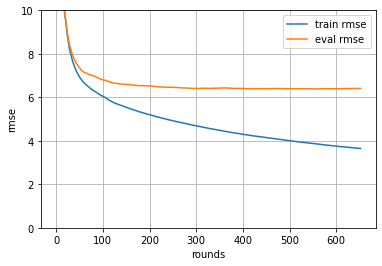

In [42]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 10)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [43]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*0.0 + y_lgb_oof_train*1.0

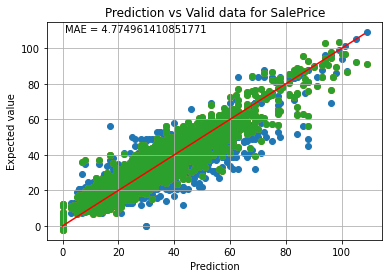

In [44]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
result_mae = mean_absolute_error(y_train, y_total_pred)
#result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [45]:
# Average of Prediction data (LightGBM)
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [46]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [47]:
submit_sample.head()

,0,1
0,2016-04-01,71.573696
1,2016-04-02,63.524904
2,2016-04-03,62.200230
3,2016-04-04,58.977760
4,2016-04-05,55.112398
